In [1]:
# 1

########## 27 February 2019 - Alec S. Hirschauer ##########
# This will be the Python notebook used for identifying
# AGB star candidates in NGC 6822 using a [8.0] vs [3.6]-[8.0]
# CMD with data from the Sibbons et al. (2012) WFCAM/UKIRT
# catalog in preparation for the Dusting the Universe
# conference which takes place in March 2019.
#
# Effectively the FOURTH iteration in evolution of this analysis,
# we are attempting to be more considerate of accounting for
# uncertainties in the determination of the color-cut boundaries.
#
# Sundar Srinivasan is currently visiting STScI (22-25 Jan 2019)
# and is helping figure out how to include the photometric
# uncertainties into the KDE analysis.
#
# Future notebooks will be based on this one, but will tackle
# additional CMDs, in no particular order:
# [3.6] vs J-[3.6] <- *THIS ONE*
# [8.0] vs [3.6]-[8.0]
# [24] vs [8.0]-[24]
# [8.0] vs J-[8.0]
# [3.6] vs [3.6]-[4.5]
# [8.0] vs [4.5]-[8.0]
#
# ^ Some of the above may be more or less useful than others,
#   but if we can get the whole process automated, then in
#   principle it wouldn't take much more time to do them all.
#
# The various populations include:
# (1) O-rich/M-type AGB star candidates
# (2) C-rich/C-type AGB star candidates
# (3) the first dusty track of O-rich AGB stars
# (4) extremely dusty sources (included with C-types)
#
# ^ Population (4) is likely some C-types + YSOs
#
# Also NB that we will detect plenty of RSG stars at similar colors
# as the AGB stars, but at lower (brighter) magnitudes.
#
# All this will be accomplished by determining first the TRGB,
# which Cioni & Habing (2005) says is at K_s = 17.10 +/- 0.01
# but Sibbons et al. (2012) says is at K_0 = 17.41 +/- 0.11.
#
# ^ TRGB for this CMD not known from the literature.
#
# I will employ histograms fit with KDE Gaussians to find the
# local minima inflection point over the relevant range of data.
#
# This technique will then also be used to determine the color cuts
# between the various populations as measured by histograms of
# optimum bin width as determined by Knuth's Algorithm.
#
# The Monte Carlo Kernel Density Estimation (MCKDE) method that we
# are developing is unfortunately probably not going to be ready
# by the time I present on 4 March 2019, so I'm going to try to
# make color cuts based on the MCKDE TRGB analysis and then
# my technique of estimating the local minima of inflection points.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.
from sklearn import neighbors
from scipy.signal import savgol_filter
# These lines are from Sundar's KDE routine

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
threesixMINUSeightzeroALL = pd.read_csv('threesixMINUSeightzeroALL.csv')

# below aren't useful yet, hold tight
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
threesixMINUSfourfiveDATA = pd.read_csv('threesixMINUSfourfive.csv')
#
# ^ Note that only the third file is necessary for THIS notebook.

In [5]:
# 5

# The first thing I'll do here is make the [8.0] vs [3.6]-[8.0] CMD & Hess diagram.

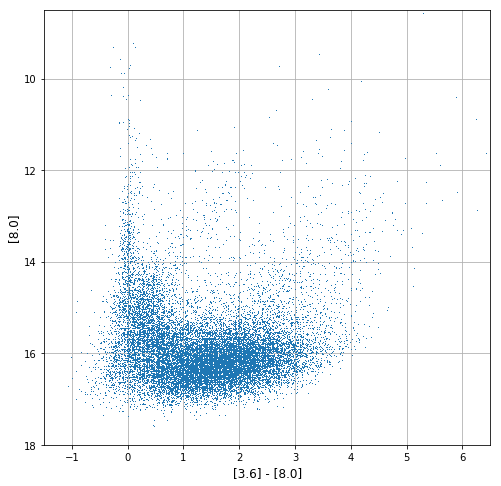

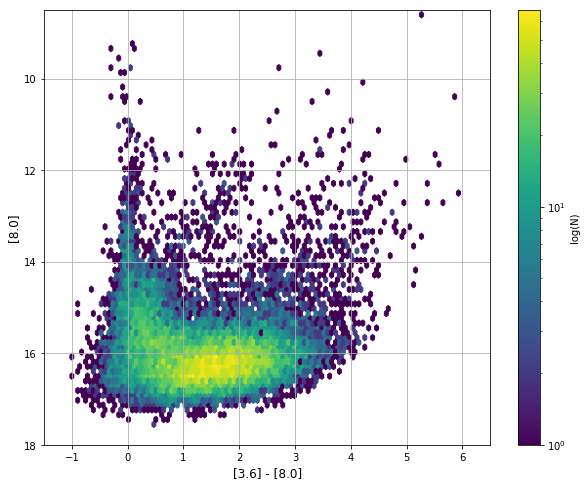

In [6]:
# 6

# [8.0] vs [3.6]-[8.0]
# CMD & Hess diagram
#
plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, ',')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_hist.pdf')

In [7]:
# 7

# The second thing I'll do is determine where the TRGB should be.
#
# With the Sibbons+ data I had a reference point, but with the Khan+ data
# I'm starting from scratch.
#
# To do so, I'll isolate only the photometric data of sources with
# errors in the magnitudes less than 0.1.

### ^ So maybe looking for the "TRGB" isn't really all the useful once you
###   get out to these longer wavelengths.
###
###   Instead, I'll be looking to establish the color-cut boundaries separating
###   out five different classifications of objects:
###
### [1] foreground and main sequence stars
###     these will be the vertical structure at color = zero
###
### [2] O-rich AGB candidates
###     these will be the cloud of points below [1], but not extending
###     up and to the right (these are C-rich AGBs) and are not the
###     large clump on the bottom right (these are background galaxies [5])
###
### [3] C-rich AGB candidates
###     these will be the structure pointing diagonally up and to the right
###     extending off of [1] and sitting above [2]
###
### [4] dust-enshrouded objects and YSOs
###     these will be the large, widespread cloud of points in the upper-right
###     region of the CMD, below and to the right of [3] and above [5]
###
### [5] background galaxies
###     these will be the large cloud of points down and to the right of [2]
###     and below [4]
###
###   I'll figure out where the various boundaries are by looking for minima
###   in KDE analyses across the entire CMD, noting that unlike CMDs 1 & 2,
###   no sources are going to be cut (like the ones previously below the TRGB).
###
###   The boundaries will have to be determined after making a photometric uncertainties
###   cut of something to the effect of removing sources with errors greater than 0.15 or so.

low_error_threesixMINUSeightzeroDATA = threesixMINUSeightzeroDATA[(threesixMINUSeightzeroDATA.e36mag < 0.15) & (threesixMINUSeightzeroDATA.e80mag < 0.15)]

# And as a check, see what the number of sources is for the entire catalog
# versus the number of sources in this trimmed catalog.

print(len(threesixMINUSeightzeroDATA))
print(len(low_error_threesixMINUSeightzeroDATA))

20414
8633


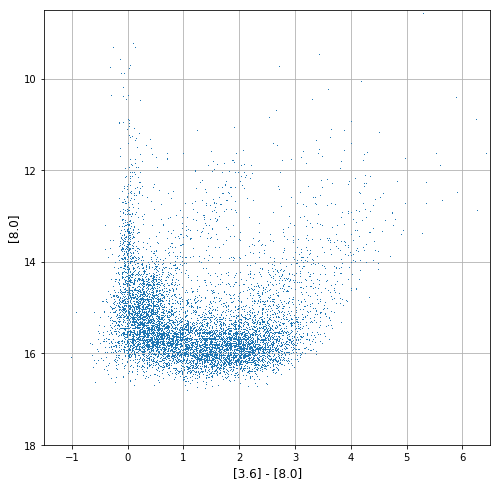

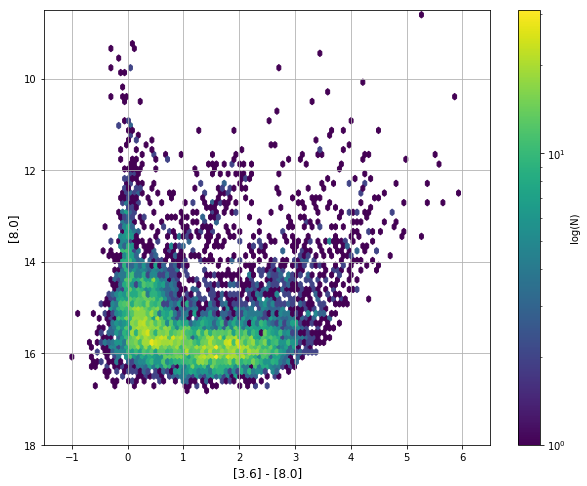

In [8]:
# 8

# With my catalog of only low-error photometry sources, I'll make a
# new CMD and Hess diagram just to see how the data look now.

# [8.0] vs [3.6]-[8.0] (low error)
# CMD & Hess diagram
#
plt.figure(figsize=(8, 8))
plt.plot(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, ',')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
plt.grid(True)
plt.show()
plt.close()
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_low_error_hist.pdf')

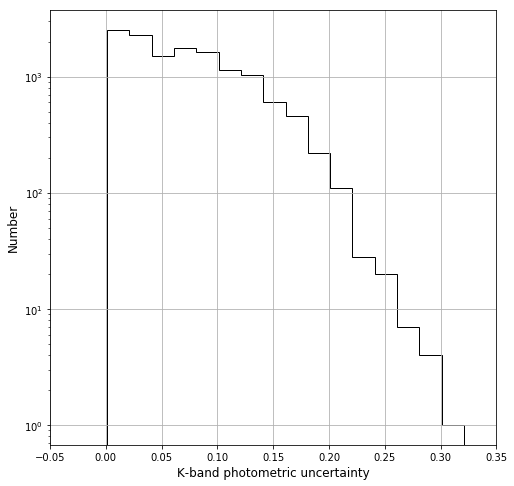

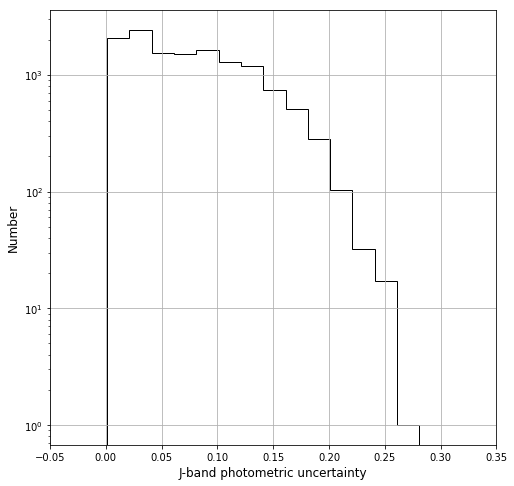

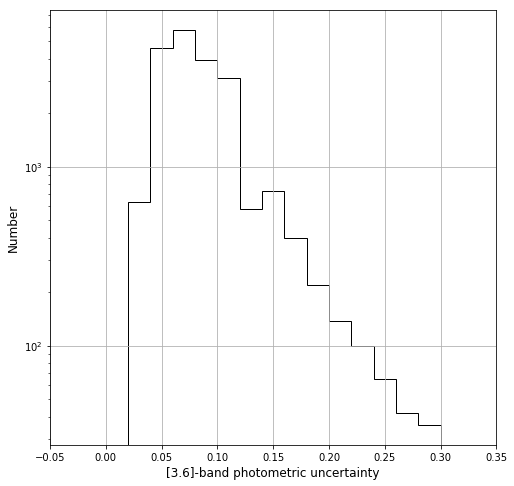

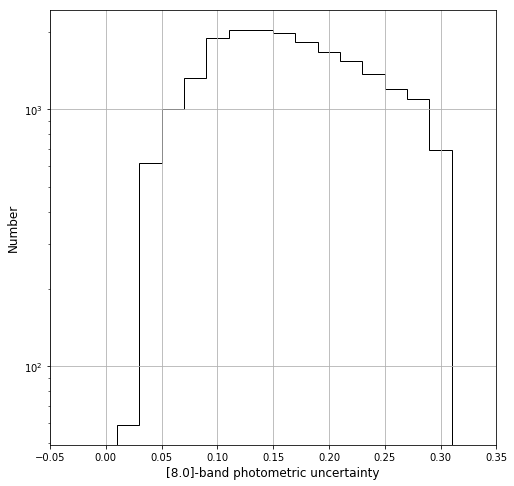

In [9]:
# 9

# What sort of error threshold should I be using?
#
# Here I'm making histograms of the photometric unertainties for
# [3.6], [8.0], J, and K.
#
# For CMD_1, the uncertainties threshold was 0.10 dex,
# which is just about where the slope of the distribution inflects
# downward, so I should look for something similar for CMD_3.
#
# How about 0.15 dex? <- inserted back into Cell #7, looks good!

binwidth = 0.02
bin_number = 100
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkDATA.eKmag, bins=np.arange(min(jMINUSkDATA.eKmag), max(jMINUSkDATA.eKmag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.05, 0.35)
plt.xlabel('K-band photometric uncertainty', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

binwidth = 0.02
bin_number = 100
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkDATA.eJmag, bins=np.arange(min(jMINUSkDATA.eJmag), max(jMINUSkDATA.eJmag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.05, 0.35)
plt.xlabel('J-band photometric uncertainty', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

binwidth = 0.02
bin_number = 100
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroDATA.e36mag, bins=np.arange(min(threesixMINUSeightzeroDATA.e36mag), max(threesixMINUSeightzeroDATA.e36mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.05, 0.35)
plt.xlabel('[3.6]-band photometric uncertainty', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

binwidth = 0.02
bin_number = 100
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroDATA.e80mag, bins=np.arange(min(threesixMINUSeightzeroDATA.e80mag), max(threesixMINUSeightzeroDATA.e80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.05, 0.35)
plt.xlabel('[8.0]-band photometric uncertainty', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

In [10]:
# 10

# Okay, now that I have a good low-error catalog for CMD_3, I can start
# chopping it up into bins of n = 1000.
#
# Since I don't have a TRGB to cut off points below, I'll just start from
# the bottom and work my way up, until I run out of points to complete a bin.
#
# Because the total length of this low-error catalog is 8633, I should have
# nine total bins, where the ninth only has about half as many points as the
# eight that precede it, but the points are going to be so diffuse that
# it shouldn't be a huge deal to figure out where the continuation of the
# various breaks in the distribution of points are located.

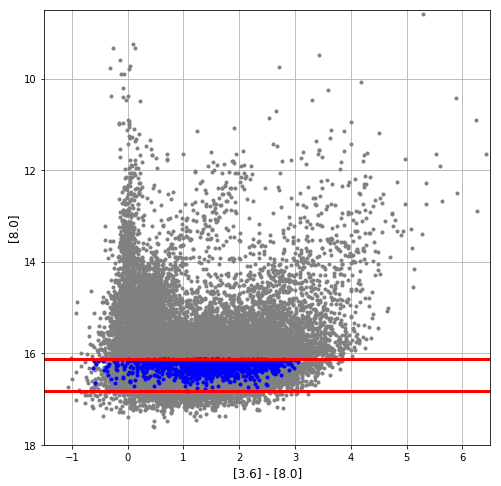

1003
16.479999999999997
0.19315789473684208


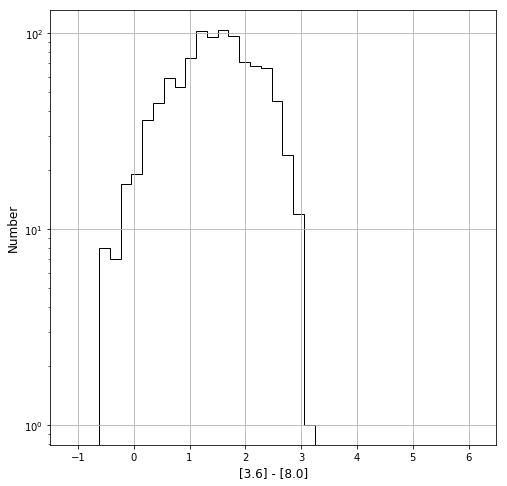

In [11]:
# 11 (Bin 1)

# [8.0] > 16.129
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag > 16.129)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=16.830, linewidth=3.0, color='red') # Bin 1 - lower boundary
plt.axhline(y=16.129, linewidth=3.0, color='red') # Bin 1 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

/Users/ahirschauer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


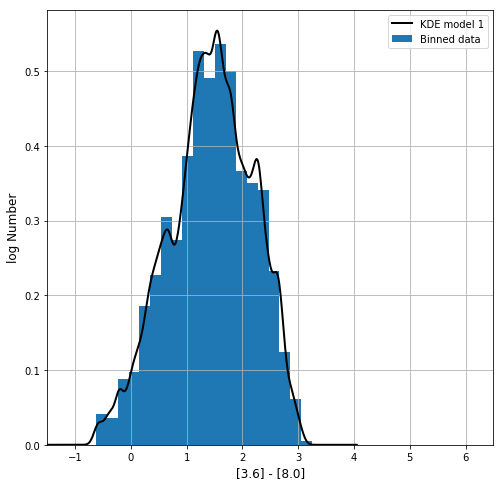

In [12]:
# 12 (Bin 1)

# [8.0] > 16.129
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 1')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(0.776, 0.78)
#plt.ylim(0.267, 0.269)
#plt.xlim(-0.315, -0.312)
#plt.ylim(0.04275, 0.043)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = -0.313
# [8.0] = 0.778

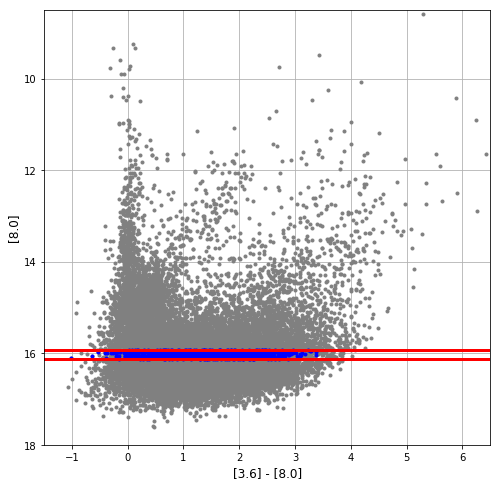

1003
16.03
0.20952380952380956


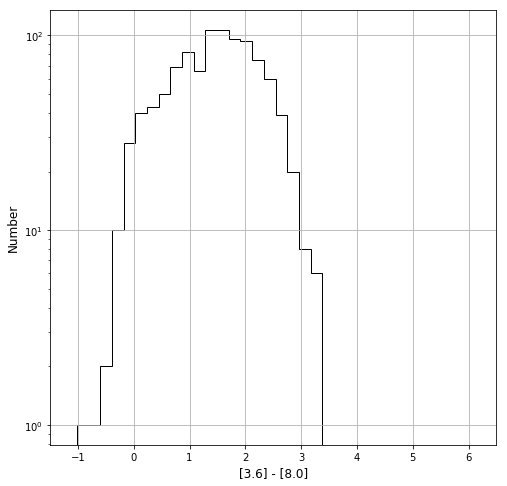

In [13]:
# 13 (Bin 2)

# [8.0] = 16.129 to 15.939
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 16.129)
                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > 15.939)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=16.129, linewidth=3.0, color='red') # Bin 2 - lower boundary
plt.axhline(y=15.939, linewidth=3.0, color='red') # Bin 2 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

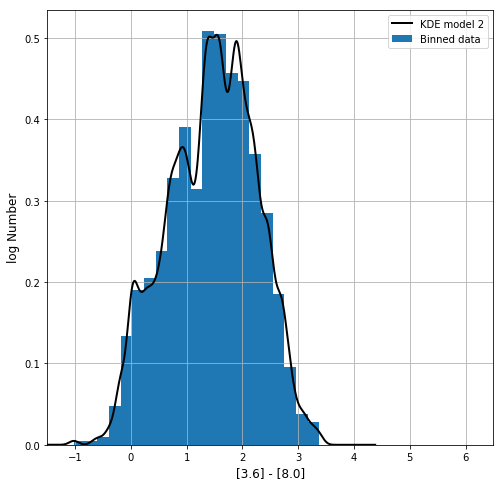

In [14]:
# 14 (Bin 2)

# [8.0] = 16.129 to 15.939
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 2')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(1.12, 1.13)
#plt.ylim(0.319, 0.321)
#plt.xlim(0.17, 0.175)
#plt.ylim(0.1785, 0.1795)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 0.173
# [8.0] = 1.122

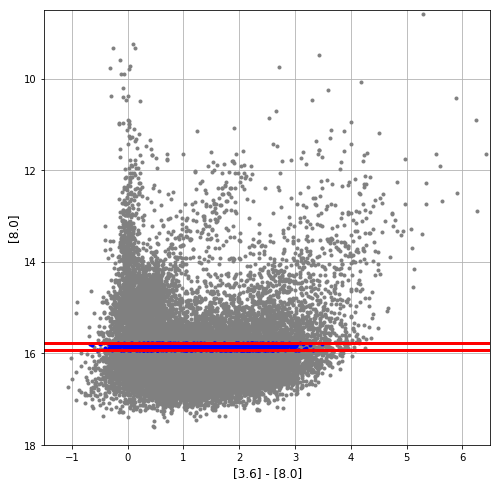

1017
15.855
0.32


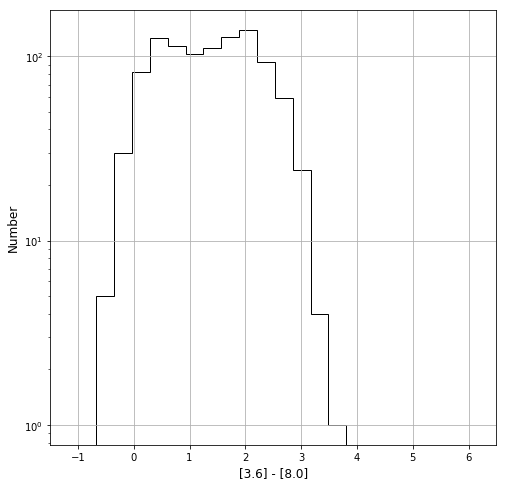

In [15]:
# 15 (Bin 3)

# [8.0] = 15.939 to 15.779
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 15.939)
                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > 15.779)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=15.939, linewidth=3.0, color='red') # Bin 3 - lower boundary
plt.axhline(y=15.779, linewidth=3.0, color='red') # Bin 3 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

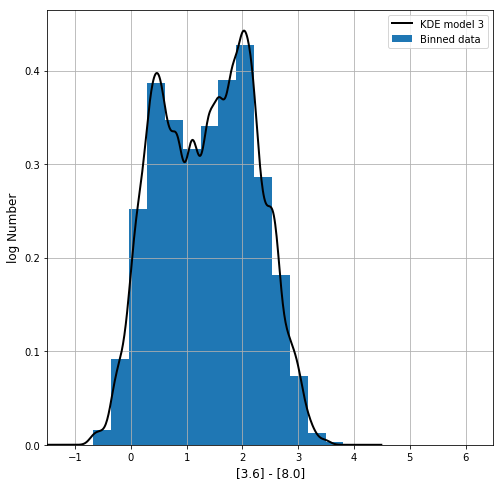

In [16]:
# 16 (Bin 3)

# [8.0] = 15.939 to 15.779
# 
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/3.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 3')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(1.24, 1.245)
#plt.ylim(0.3085, 0.3090)
#plt.xlim(0.72, 0.73)
#plt.ylim(0.3315, 0.3325)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 0.725
# [8.0] = 1.243

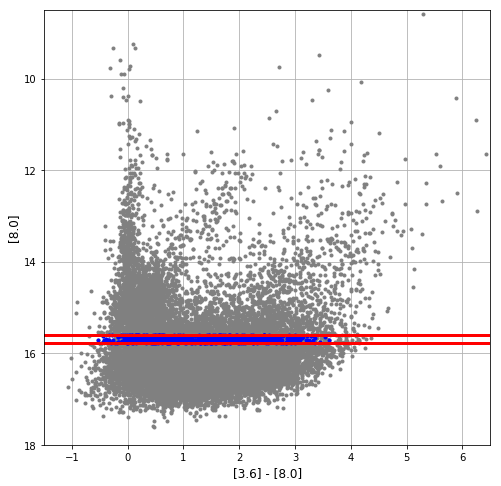

1062
15.69
0.25875000000000004


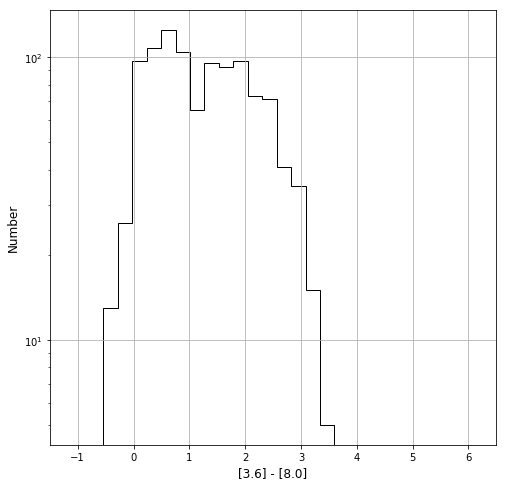

In [17]:
# 17 (Bin 4)

# [8.0] = 15.779 to 15.609
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 15.779)
                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > 15.609)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=15.779, linewidth=3.0, color='red') # Bin 4 - lower boundary
plt.axhline(y=15.609, linewidth=3.0, color='red') # Bin 4 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

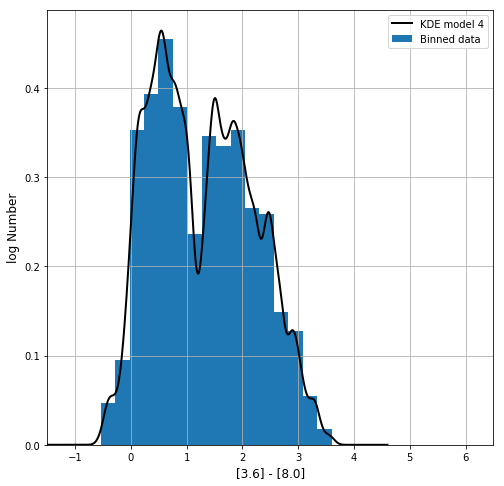

In [18]:
# 18 (Bin 4)

# [8.0] = 15.779 to 15.609
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/3.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 4')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(1.215, 1.2175)
#plt.ylim(0.20813, 0.20815)
#plt.xlim(0.24, 0.25)
#plt.ylim(0.373, 0.375)
#plt.xlim(0.705, 0.72)
#plt.ylim(0.406, 0.407)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 0.244 -> 0.712
# [8.0] = 1.216

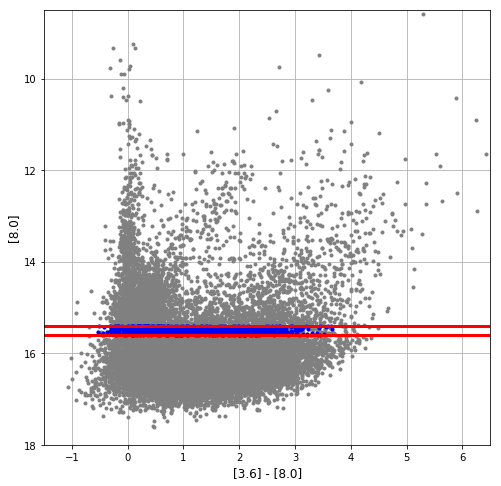

1005
15.5
0.28


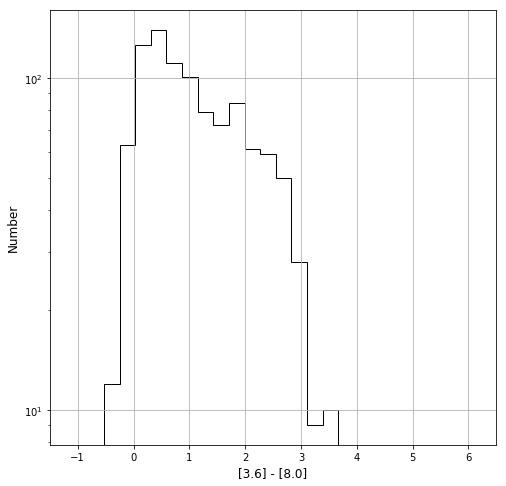

In [19]:
# 19 (Bin 5)

# [8.0] = 15.609 to 15.399
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 15.609)
                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > 15.399)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=15.609, linewidth=3.0, color='red') # Bin 5 - lower boundary
plt.axhline(y=15.399, linewidth=3.0, color='red') # Bin 5 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

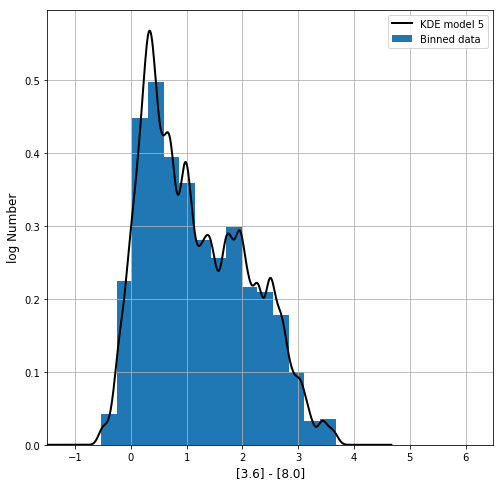

In [20]:
# 20 (Bin 5)

# [8.0] = 15.609 to 15.399
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/3.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 5')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(1.5635, 1.564)
#plt.ylim(0.25265, 0.2527)
#plt.xlim(0.842, 0.844)
#plt.ylim(0.34250, 0.34275)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 0.843
# [8.0] = 1.564

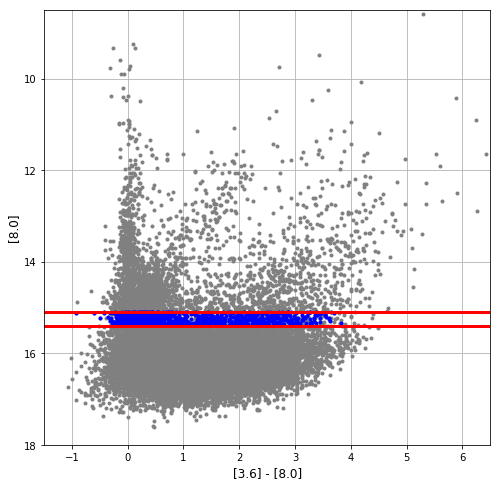

1008
15.24
0.31666666666666665


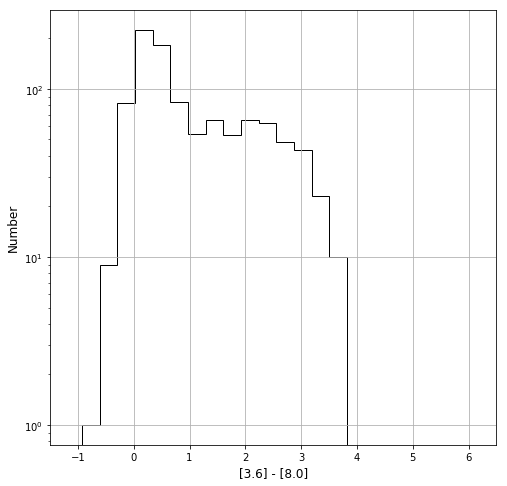

In [21]:
# 21 (Bin 6)

# [8.0] = 15.399 to 15.089
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 15.399)
                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > 15.089)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=15.399, linewidth=3.0, color='red') # Bin 6 - lower boundary
plt.axhline(y=15.089, linewidth=3.0, color='red') # Bin 6 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

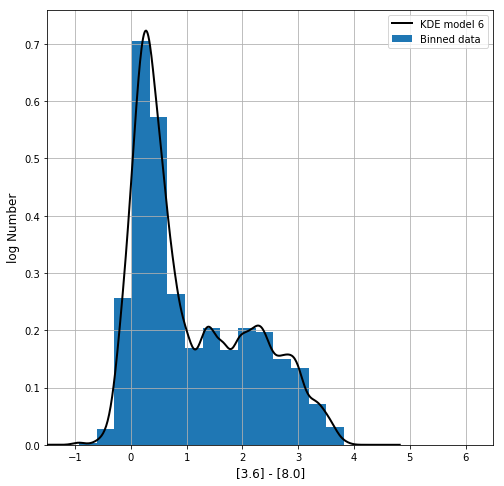

In [22]:
# 22 (Bin 6)

# [8.0] = 15.399 to 15.089
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/3.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 6')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(2.65, 2.66)
#plt.ylim(0.155, 0.156)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 1.154
# [8.0] = 1.790
# [8.0] = 2.656

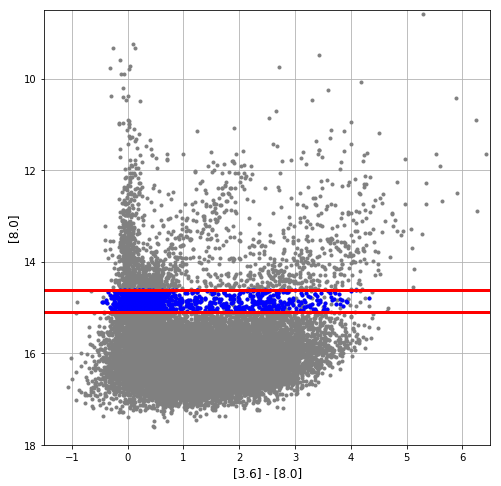

1005
14.844999999999999
0.2811764705882353


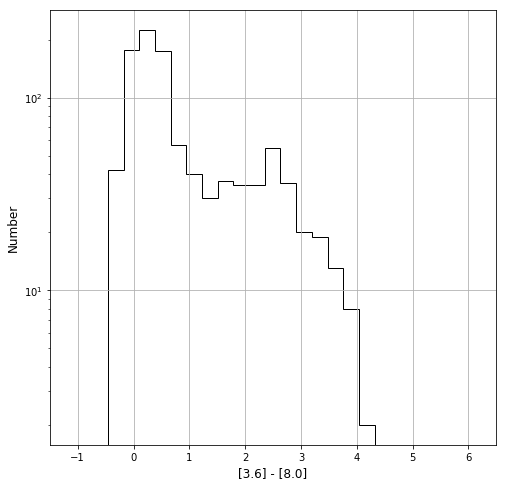

In [23]:
# 23 (Bin 7)

# [8.0] = 15.089 to 14.609
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 15.089)
                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > 14.609)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=15.089, linewidth=3.0, color='red') # Bin 7 - lower boundary
plt.axhline(y=14.609, linewidth=3.0, color='red') # Bin 7 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

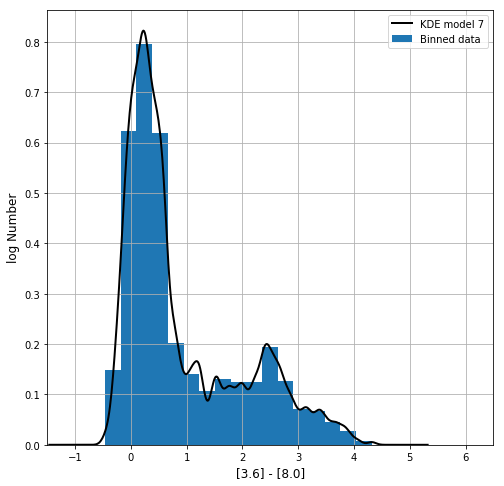

In [24]:
# 24 (Bin 7)

# [8.0] = 15.089 to 14.609
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/4.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 7')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(1.375, 1.385)
#plt.ylim(0.087, 0.088)
#plt.xlim(3.035, 3.040)
#plt.ylim(0.06975, 0.07)
#plt.xlim(4.2, 4.21)
#plt.ylim(0.0033, 0.0035)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 1.393 -> 1.380
# maybe something at = 0.0-ish?
# [8.0] = 3.037 -> 4.206

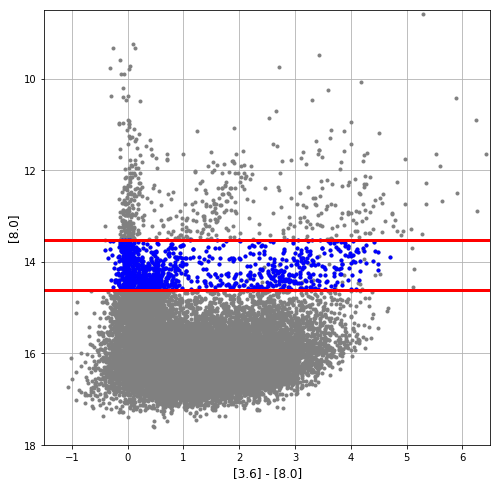

1005
14.059999999999999
0.3930769230769231


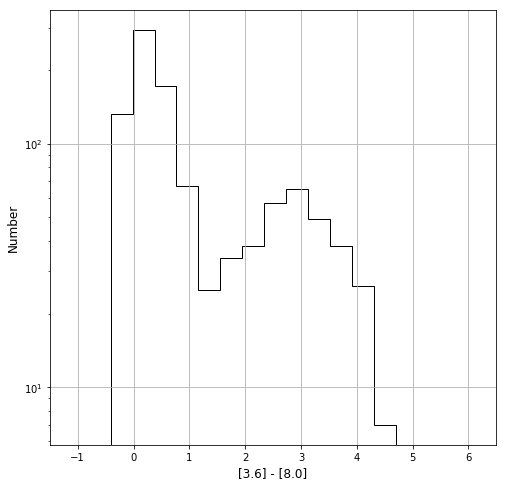

In [25]:
# 25 (Bin 8)

# [8.0] = 14.609 to 13.519
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 14.609)
                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > 13.519)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=14.609, linewidth=3.0, color='red') # Bin 8 - lower boundary
plt.axhline(y=13.519, linewidth=3.0, color='red') # Bin 8 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

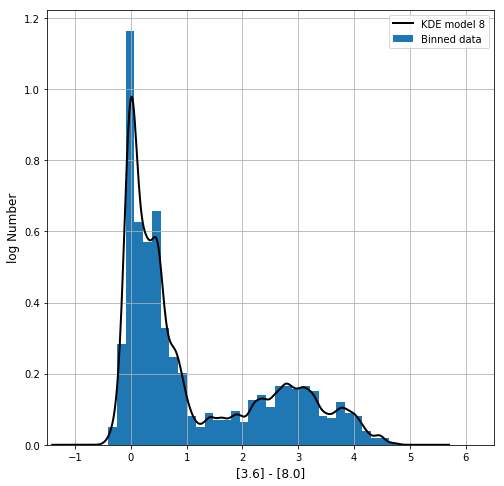

In [26]:
# 26 (Bin 8)

# [8.0] = 14.609 to 13.519
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/2.5, binwidth/2.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/6.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 8')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(2.45, 2.453)
#plt.ylim(0.1272, 0.1274)
#plt.xlim(4.360, 4.3615)
#plt.ylim(0.0254, 0.02545)
#plt.xlim(4.3, 5.9)
#plt.ylim(0.0, 0.1)
#plt.xlim(2.45, 2.4525)
#plt.ylim(0.1272, 0.1274)
#plt.xlim(2.02, 2.03)
#plt.ylim(0.078, 0.080)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 0.343
# [8.0] = 1.240 -> 2.024
# [8.0] = 2.451 -> 4.361?

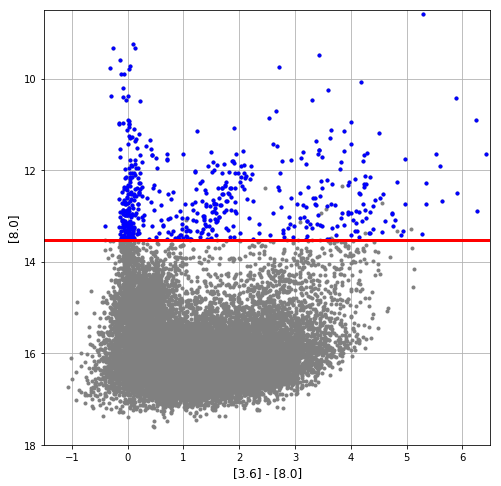

525
11.045
0.670909090909091


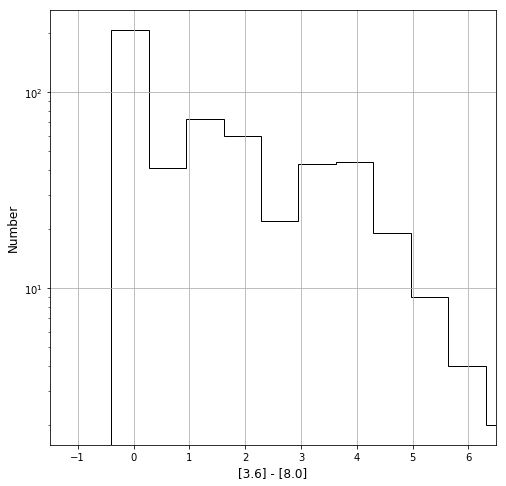

In [27]:
# 27 (Bin 9)

# [8.0] < 13.519
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 13.519)]
#                                                                 & (low_error_threesixMINUSeightzeroDATA.k80mag > )]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axhline(y=13.519, linewidth=3.0, color='red') # Bin 9 - lower boundary
#plt.axhline(y=, linewidth=3.0, color='red') # Bin 9 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
#print(max(threesixMINUSeightzeroHIST.k80mag))
#print(min(threesixMINUSeightzeroHIST.k80mag))
print(((max(threesixMINUSeightzeroHIST.k80mag))+(min(threesixMINUSeightzeroHIST.k80mag)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroHIST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.threesixMINUSeightzero, bins=np.arange(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero), max(threesixMINUSeightzeroHIST.threesixMINUSeightzero) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-1.5, 6.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

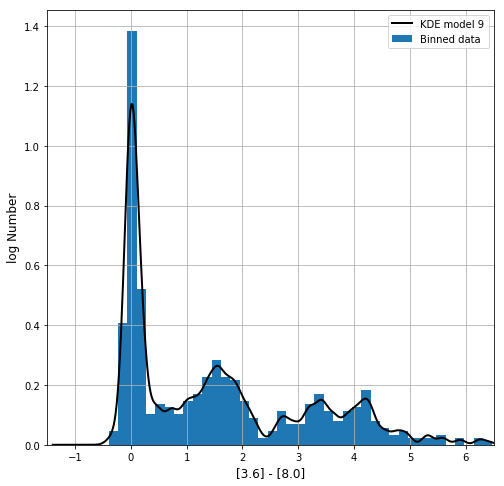

In [28]:
# 28 (Bin 9)

# [8.0] < 13.519
#
kde_data = threesixMINUSeightzeroHIST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/4., binwidth/4.)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/12.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 9')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(-1.5, 6.5)
#plt.xlim(2.42, 2.44)
#plt.ylim(0.027, 0.028)

plt.legend()
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [8.0] = 0.837
# [8.0] = 2.435

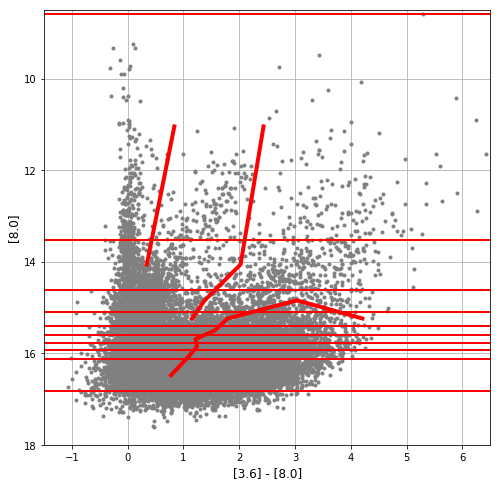

In [29]:
# 29

# CMD with horizontal bins

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)

#
### where are the magnitude span bin midpoints?
#
#plt.axhline(y=16.480, linewidth=1.0, color='cyan')
#plt.axhline(y=16.030, linewidth=1.0, color='cyan')
#plt.axhline(y=15.855, linewidth=1.0, color='cyan')
#plt.axhline(y=15.690, linewidth=1.0, color='cyan')
#plt.axhline(y=15.500, linewidth=1.0, color='cyan')
#plt.axhline(y=15.240, linewidth=1.0, color='cyan')
#plt.axhline(y=14.845, linewidth=1.0, color='cyan')
#plt.axhline(y=14.060, linewidth=1.0, color='cyan')
#plt.axhline(y=11.045, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axhline(y=16.83, linewidth=2.0, color='red')
plt.axhline(y=16.129, linewidth=2.0, color='red')
plt.axhline(y=15.939, linewidth=2.0, color='red')
plt.axhline(y=15.779, linewidth=2.0, color='red')
plt.axhline(y=15.609, linewidth=2.0, color='red')
plt.axhline(y=15.399, linewidth=2.0, color='red')
plt.axhline(y=15.089, linewidth=2.0, color='red')
plt.axhline(y=14.609, linewidth=2.0, color='red')
plt.axhline(y=13.519, linewidth=2.0, color='red')
plt.axhline(y=8.58, linewidth=2.0, color='red')
#
### plot points
#
yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 15.240])#, 14.060])#, 11.045])
yvalues2 = np.array([15.240, 14.845, 14.060, 11.045])
yvalues3 = np.array([14.060, 11.045])
boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.790, 3.037, 4.206])#, 2.435])
boundary2 = np.array([1.154, 1.380, 2.024, 2.435])
boundary3 = np.array([0.343, 0.837])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_bins_red.pdf')


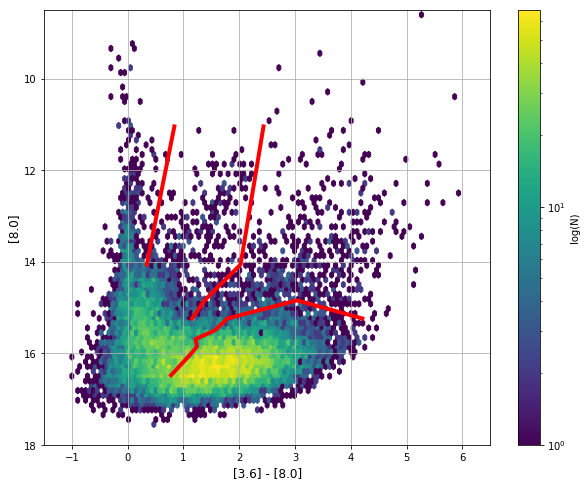

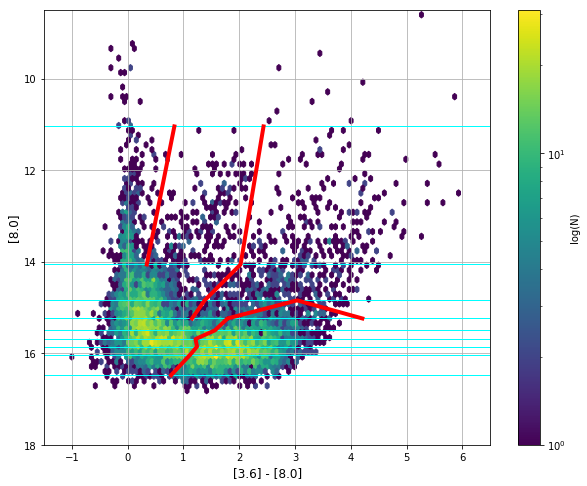

In [30]:
# 30

fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')

#
### where are the magnitude span bin midpoints?
#
#plt.axhline(y=16.480, linewidth=1.0, color='cyan')
#plt.axhline(y=16.030, linewidth=1.0, color='cyan')
#plt.axhline(y=15.855, linewidth=1.0, color='cyan')
#plt.axhline(y=15.690, linewidth=1.0, color='cyan')
#plt.axhline(y=15.500, linewidth=1.0, color='cyan')
#plt.axhline(y=15.240, linewidth=1.0, color='cyan')
#plt.axhline(y=14.845, linewidth=1.0, color='cyan')
#plt.axhline(y=14.060, linewidth=1.0, color='cyan')
#plt.axhline(y=11.045, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
#plt.axhline(y=16.83, linewidth=2.0, color='red')
#plt.axhline(y=16.129, linewidth=2.0, color='red')
#plt.axhline(y=15.939, linewidth=2.0, color='red')
#plt.axhline(y=15.779, linewidth=2.0, color='red')
#plt.axhline(y=15.609, linewidth=2.0, color='red')
#plt.axhline(y=15.399, linewidth=2.0, color='red')
#plt.axhline(y=15.089, linewidth=2.0, color='red')
#plt.axhline(y=14.609, linewidth=2.0, color='red')
#plt.axhline(y=13.519, linewidth=2.0, color='red')
#plt.axhline(y=8.58, linewidth=2.0, color='red')
#
### plot points
#
yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 15.240])#, 14.060])#, 11.045])
yvalues2 = np.array([15.240, 14.845, 14.060, 11.045])
yvalues3 = np.array([14.060, 11.045])
boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.790, 3.037, 4.206])#, 2.435])
boundary2 = np.array([1.154, 1.380, 2.024, 2.435])
boundary3 = np.array([0.343, 0.837])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_hist_binlines.pdf')

#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')

#
### where are the magnitude span bin midpoints?
#
plt.axhline(y=16.480, linewidth=1.0, color='cyan')
plt.axhline(y=16.030, linewidth=1.0, color='cyan')
plt.axhline(y=15.855, linewidth=1.0, color='cyan')
plt.axhline(y=15.690, linewidth=1.0, color='cyan')
plt.axhline(y=15.500, linewidth=1.0, color='cyan')
plt.axhline(y=15.240, linewidth=1.0, color='cyan')
plt.axhline(y=14.845, linewidth=1.0, color='cyan')
plt.axhline(y=14.060, linewidth=1.0, color='cyan')
plt.axhline(y=11.045, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
#plt.axhline(y=16.83, linewidth=2.0, color='red')
#plt.axhline(y=16.129, linewidth=2.0, color='red')
#plt.axhline(y=15.939, linewidth=2.0, color='red')
#plt.axhline(y=15.779, linewidth=2.0, color='red')
#plt.axhline(y=15.609, linewidth=2.0, color='red')
#plt.axhline(y=15.399, linewidth=2.0, color='red')
#plt.axhline(y=15.089, linewidth=2.0, color='red')
#plt.axhline(y=14.609, linewidth=2.0, color='red')
#plt.axhline(y=13.519, linewidth=2.0, color='red')
#plt.axhline(y=8.58, linewidth=2.0, color='red')
#
### plot points
#
yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 15.240])#, 14.060])#, 11.045])
yvalues2 = np.array([15.240, 14.845, 14.060, 11.045])
yvalues3 = np.array([14.060, 11.045])
boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.790, 3.037, 4.206])#, 2.435])
boundary2 = np.array([1.154, 1.380, 2.024, 2.435])
boundary3 = np.array([0.343, 0.837])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_low-error_hist_binlines.pdf')

In [31]:
# 31

# I get the feeling that I'd be better off doing vertical bins
# rather than horizontal bins.

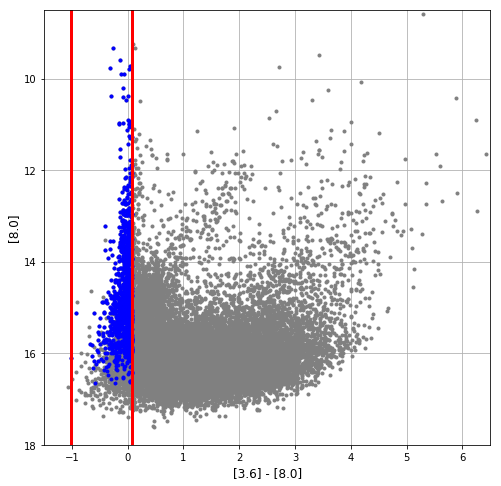

1029
0.07
-1.02
-0.475
0.2927999999999997


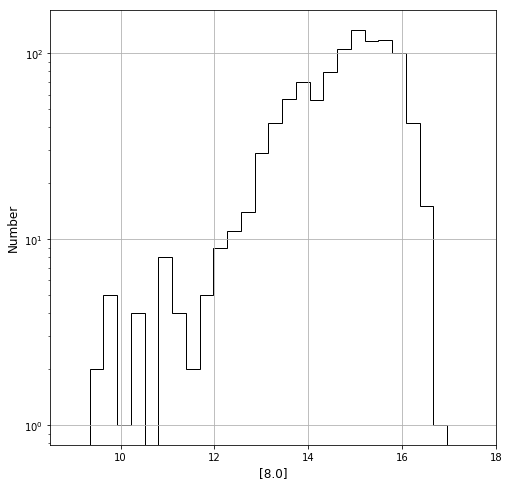

In [32]:
# 32 (Bin A)

# [3.6]-[8.0] = -1.02 to 0.071
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 0.071)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=0.071, linewidth=3.0, color='red') # Bin A - right boundary
plt.axvline(x=-1.02, linewidth=3.0, color='red') # Bin A - left boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

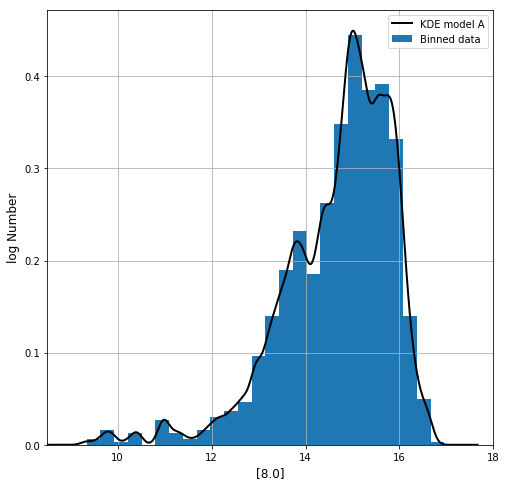

In [33]:
# 33 (Bin A)

# [3.6]-[8.0] = -1.02 to 0.071
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/3.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model A')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(14.09, 14.095)
#plt.ylim(0.196, 0.1965)
#plt.xlim(15.415, 15.4225)
#plt.ylim(0.37, 0.371)
#plt.xlim(11.565, 11.58)
#plt.ylim(0.0074, 0.0075)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = 11.571
# [3.6]-[8.0] = 14.093
# [3.6]-[8.0] = 15.419

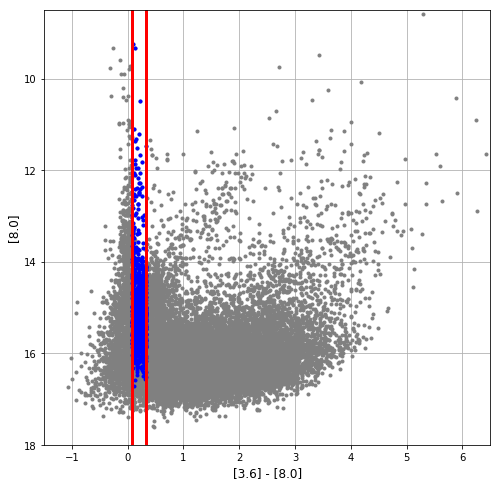

1019
0.33
0.08
0.20500000000000002
0.1915384615384621


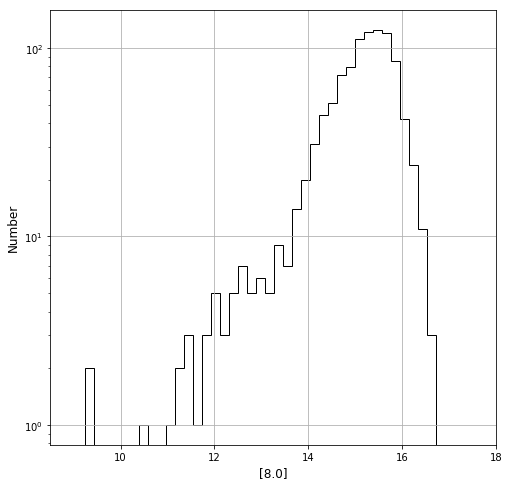

In [34]:
# 34 (Bin B)

# [3.6]-[8.0] = 0.071 to 0.331
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 0.071)
                                                                 & (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 0.331)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=0.071, linewidth=3.0, color='red') # Bin B - left boundary
plt.axvline(x=0.331, linewidth=3.0, color='red') # Bin B - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

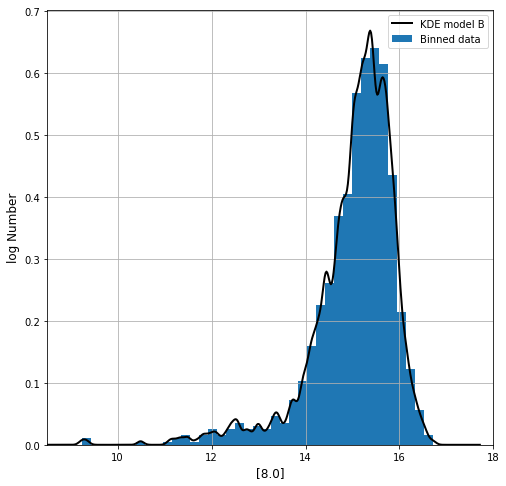

In [35]:
# 35 (Bin B)

# [3.6]-[8.0] = 0.071 to 0.331
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model B')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(14.539, 14.542)
#plt.ylim(0.259, 0.2595)
#plt.xlim(13.52, 13.55)
#plt.ylim(0.035, 0.036)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = 13.535
# [3.6]-[8.0] = 14.541

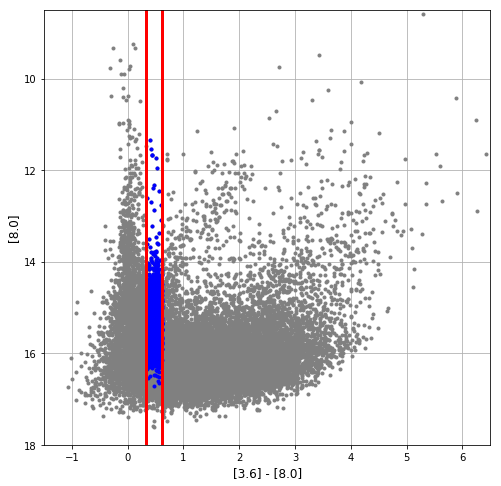

1027
0.61
0.34
0.475
0.15794117647058847


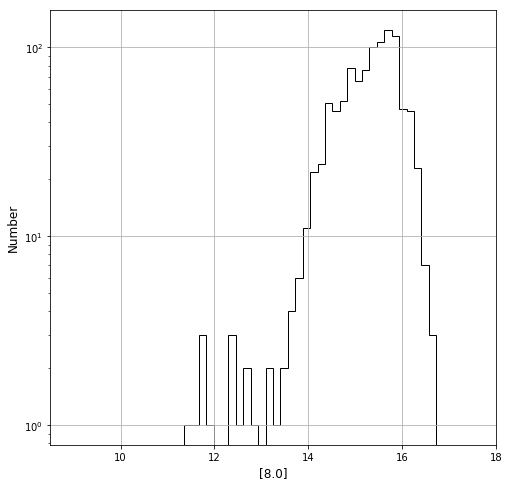

In [36]:
# 36 (Bin C)

# [3.6]-[8.0] = 0.331 to 0.611
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 0.331)
                                                                 & (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 0.611)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=0.331, linewidth=3.0, color='red') # Bin C - left boundary
plt.axvline(x=0.611, linewidth=3.0, color='red') # Bin C - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

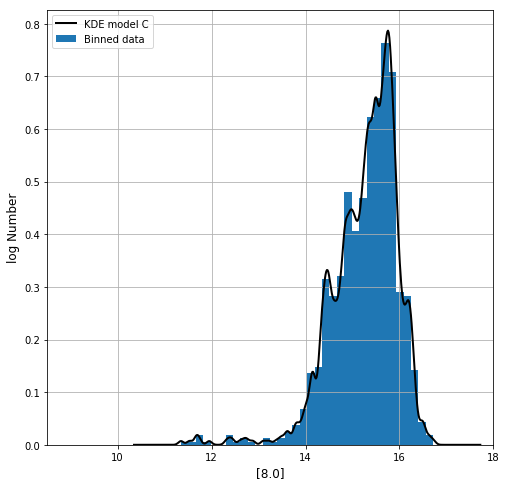

In [37]:
# 37 (Bin C)

# [3.6]-[8.0] = 0.331 to 0.611
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model C')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(12.990, 12.995)
#plt.ylim(0.0015, 0.0025)
#plt.xlim(14.218, 14.221)
#plt.ylim(0.125, 0.13)
#plt.xlim(14.625, 14.64)
#plt.ylim(0.273, 0.274)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = 12.994?
# [3.6]-[8.0] = 14.220
# [3.6]-[8.0] = 14.633

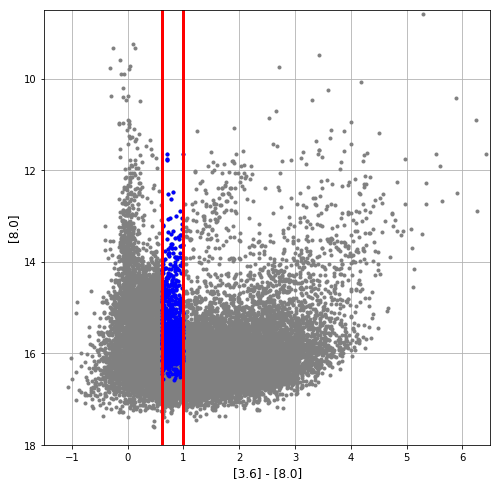

1000
0.99
0.62
0.8049999999999999
0.13000000000000078


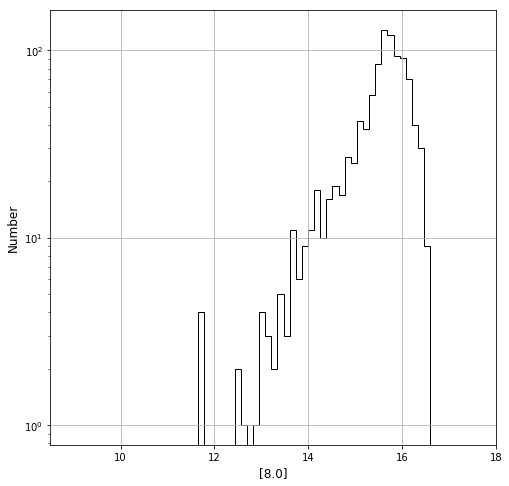

In [38]:
# 38 (Bin D)

# [3.6]-[8.0] = 0.611 to 0.991
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 0.611)
                                                                 & (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 0.991)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=0.611, linewidth=3.0, color='red') # Bin D - left boundary
plt.axvline(x=0.991, linewidth=3.0, color='red') # Bin D - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

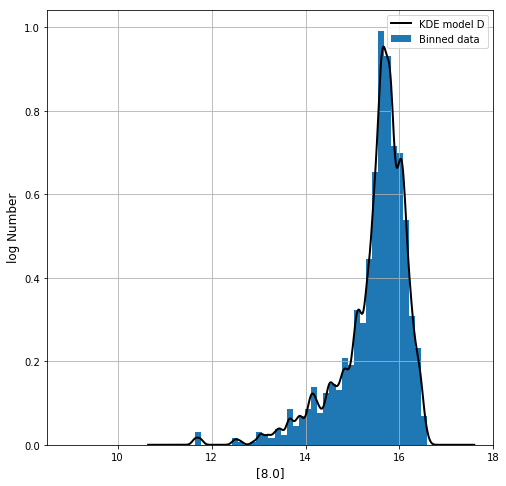

In [39]:
# 39 (Bin D)

# [3.6]-[8.0] = 0.611 to 0.991
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/1.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model D')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(12.76, 12.77)
#plt.ylim(0.001, 0.00125)
#plt.xlim(14.33, 14.34)
#plt.ylim(0.086, 0.087)
#plt.xlim(15.19, 15.20)
#plt.ylim(0.313, 0.3145)
#plt.xlim(14.889, 14.895)
#plt.ylim(0.1807, 0.1808)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = 12.764
# [3.6]-[8.0] = 14.336
# [3.6]-[8.0] = 15.198 -> 14.892

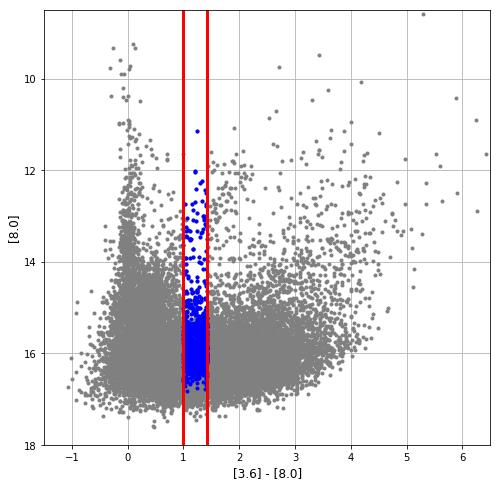

1012
1.43
1.0
1.2149999999999999
0.11854166666666721


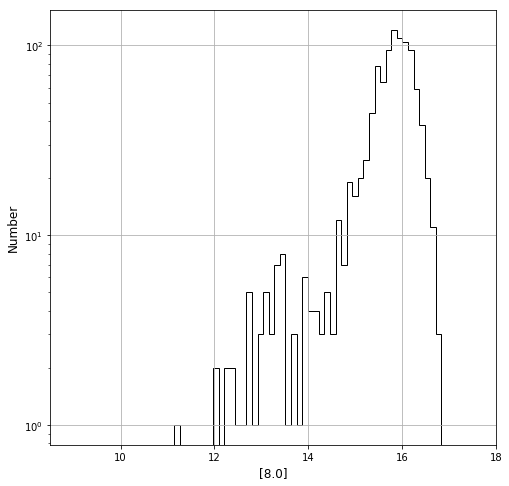

In [40]:
# 40 (Bin E)

# [3.6]-[8.0] = 0.991 to 1.431
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 0.991)
                                                                 & (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 1.431)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=0.991, linewidth=3.0, color='red') # Bin E - left boundary
plt.axvline(x=1.431, linewidth=3.0, color='red') # Bin E - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

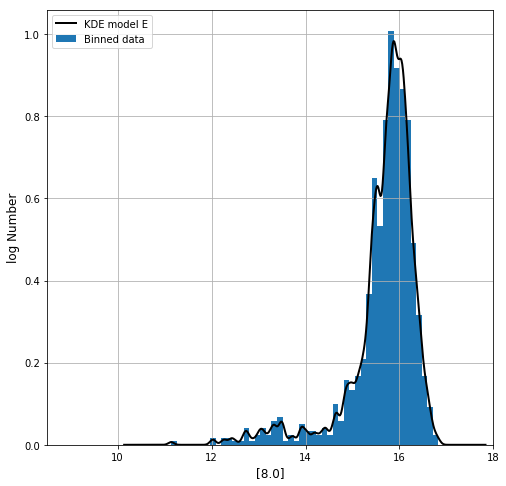

In [41]:
# 41 (Bin E)

# [3.6]-[8.0] = 0.991 to 1.431
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/1.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model E')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(14.71, 14.725)
#plt.ylim(0.0715, 0.072)
#plt.xlim(15.59, 15.6)
#plt.ylim(0.60589, 0.60591)
#plt.xlim(13.5, 13.9)
#plt.ylim(0.01, 0.03)
#plt.xlim(14.111, 14.121)
#plt.ylim(0.025, 0.026)
#plt.xlim(11.565, 11.58)
#plt.ylim(0.00000000000002, 0.00000000000004)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = 14.717
# [3.6]-[8.0] = 15.595
# [3.6]-[8.0] = 14.116
# [3.6]-[8.0] = 11.573

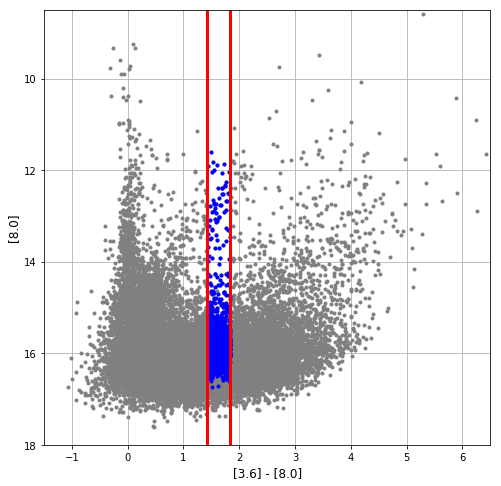

1012
1.83
1.44
1.635
0.10914893617021271


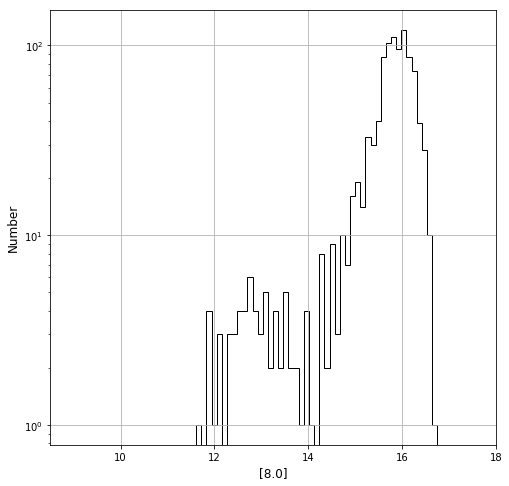

In [42]:
# 42 (Bin F)

# [3.6]-[8.0] = 1.431 to 1.831
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 1.431)
                                                                 & (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 1.831)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=1.431, linewidth=3.0, color='red') # Bin F - left boundary
plt.axvline(x=1.831, linewidth=3.0, color='red') # Bin F - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

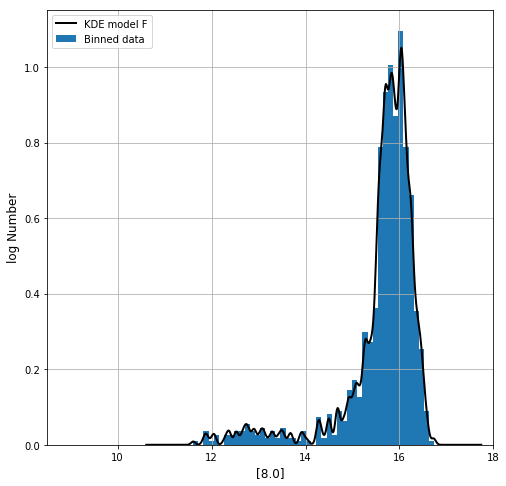

In [43]:
# 43 (Bin F)

# [3.6]-[8.0] = 1.431 to 1.831
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.0)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model F')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(13.795, 13.8)
#plt.ylim(0.004, 0.0041)
#plt.xlim(13.793, 13.8)
#plt.ylim(0.0093, 0.0094)
#plt.xlim(15.138, 15.141)
#plt.ylim(0.157, 0.1572)
#plt.xlim(15.3375, 15.3415)
#plt.ylim(0.269, 0.270)
#plt.xlim(14.76, 14.775)
#plt.ylim(0.063, 0.065)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = XXX
# [3.6]-[8.0] = 13.796
# [3.6]-[8.0] = 15.139 -> 15.340x -> 14.768
# [3.6]-[8.0] = 

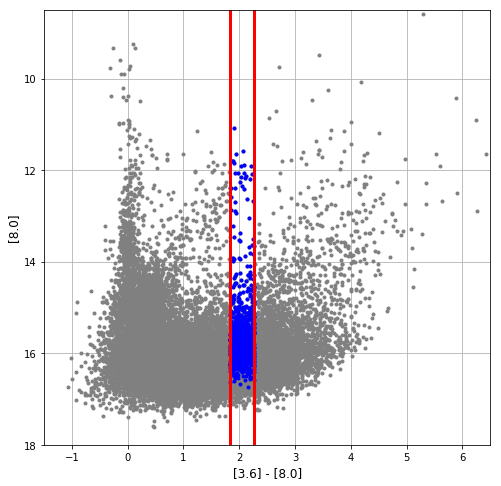

1019
2.27
1.84
2.055
0.09758620689655118


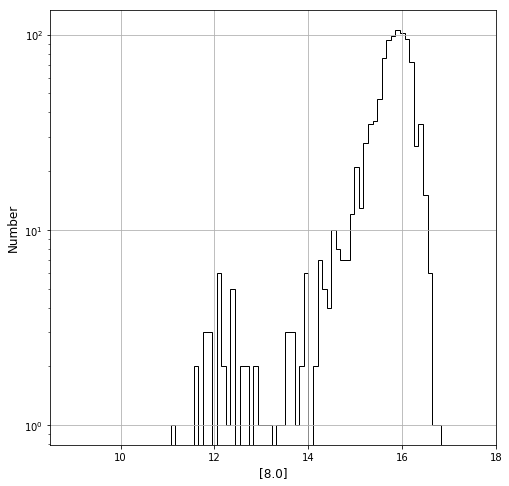

In [44]:
# 44 (Bin G)

# [3.6]-[8.0] = 1.831 to 2.271
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 1.831)
                                                                 & (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 2.271)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=1.831, linewidth=3.0, color='red') # Bin G - left boundary
plt.axvline(x=2.271, linewidth=3.0, color='red') # Bin G - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

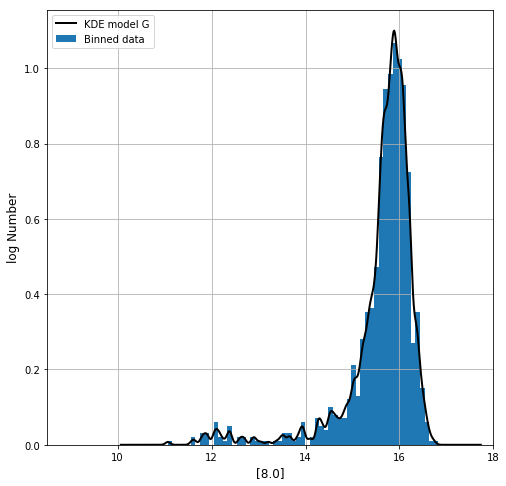

In [45]:
# 45 (Bin G)

# [3.6]-[8.0] = 1.831 to 2.271
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/1.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model G')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(14.085, 14.1)
#plt.ylim(0.018, 0.01875)
#plt.xlim(14.715, 14.725)
#plt.ylim(0.07, 0.0715)
#plt.xlim(13.29, 13.30)
#plt.ylim(0.0045, 0.005)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = XXX
# [3.6]-[8.0] = 14.092 -> 14.721
# [3.6]-[8.0] = 13.294
# [3.6]-[8.0] = 

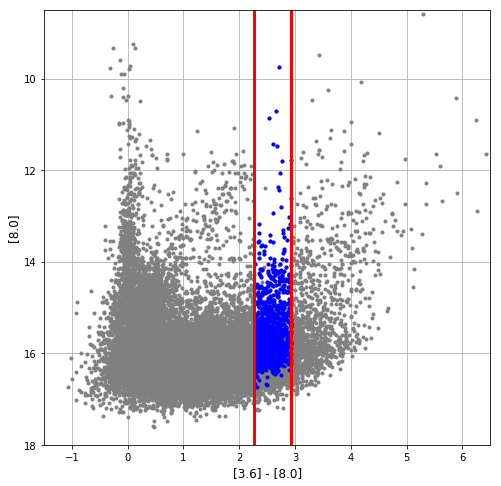

1008
2.93
2.28
2.605
0.15886363636363576


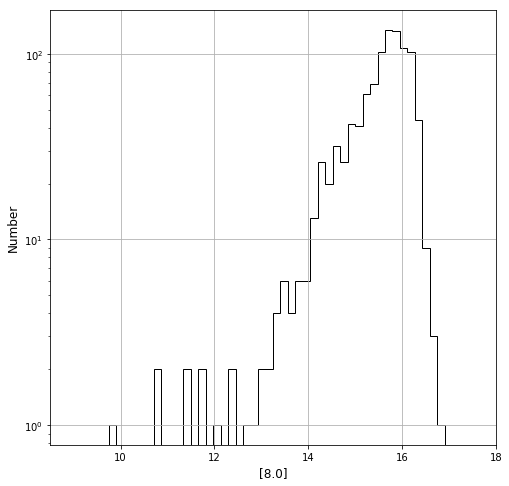

In [46]:
# 46 (Bin H)

# [3.6]-[8.0] = 2.271 to 2.931
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 2.271)
                                                                 & (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 2.931)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=2.271, linewidth=3.0, color='red') # Bin H - left boundary
plt.axvline(x=2.931, linewidth=3.0, color='red') # Bin H - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

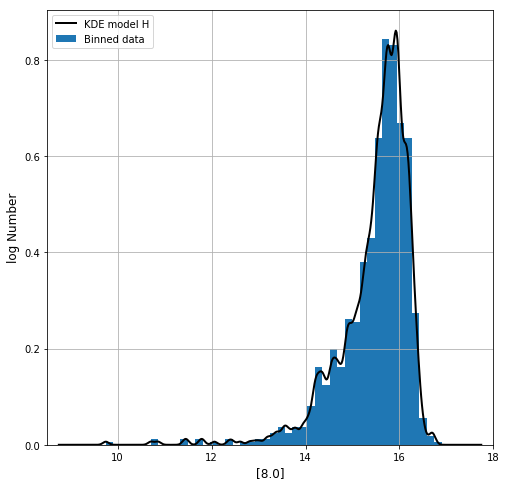

In [47]:
# 47 (Bin H)

# [3.6]-[8.0] = 2.271 to 2.931
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model H')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(14.745, 14.755)
#plt.ylim(0.16775, 0.16825)
#plt.xlim(12.707, 12.719)
#plt.ylim(0.0034, 0.0035)
#plt.xlim(8.0, 10.0)
#plt.ylim(0.0, 0.001)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = XXX -> 9.5?
# [3.6]-[8.0] = 14.749
# [3.6]-[8.0] = 12.714

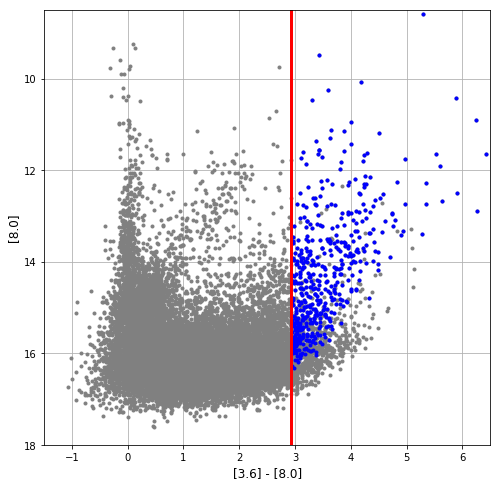

507
6.98
2.94
4.96
0.40736842105263094


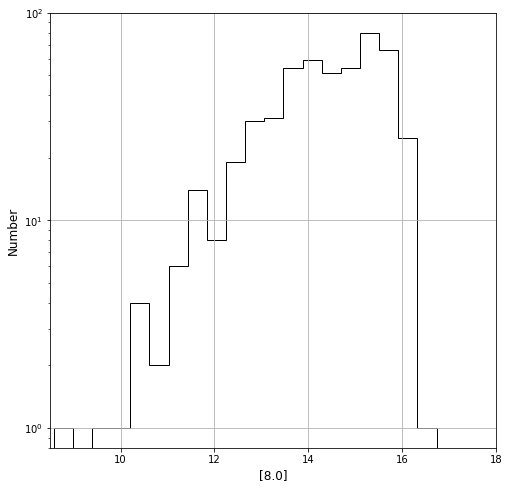

In [48]:
# 48 (Bin I)

# [3.6]-[8.0] = 2.931 to 6.98
#
threesixMINUSeightzeroHIST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero > 2.931)]
                                                                 #& (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 6.98)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroHIST.threesixMINUSeightzero, threesixMINUSeightzeroHIST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_plot.pdf')
#
plt.axvline(x=2.931, linewidth=3.0, color='red') # Bin I - left boundary
plt.axvline(x=6.98, linewidth=3.0, color='red') # Bin I - right boundary
#
plt.grid(True)
plt.show()
plt.close()
#
print(len(threesixMINUSeightzeroHIST))
#
print(max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero))
print(((max(threesixMINUSeightzeroHIST.threesixMINUSeightzero))+(min(threesixMINUSeightzeroHIST.threesixMINUSeightzero)))/2.)
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroHIST.k80mag)
bin_number = (max(threesixMINUSeightzeroHIST.k80mag)+binwidth)/binwidth
print(binwidth)
#
fig = plt.figure(figsize = (8,8))
plt.hist(threesixMINUSeightzeroHIST.k80mag, bins=np.arange(min(threesixMINUSeightzeroHIST.k80mag), max(threesixMINUSeightzeroHIST.k80mag) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(8.5, 18.0)
plt.xlabel('[8.0]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

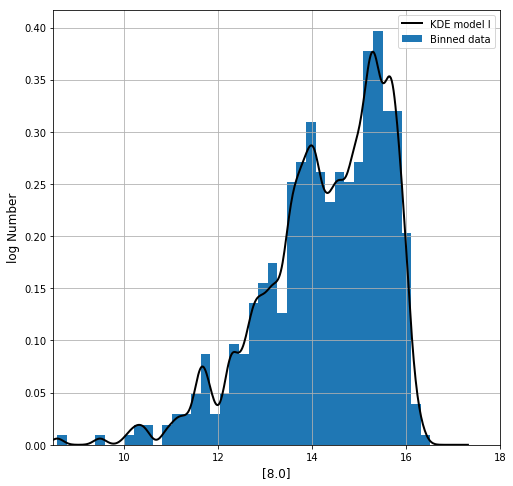

In [49]:
# 49 (Bin I)

# [3.6]-[8.0] = 2.931 to 6.98
#
kde_data = threesixMINUSeightzeroHIST.k80mag.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/2., binwidth/2.)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/4.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model I')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

plt.xlim(8.5, 18.0)
#plt.xlim(15.52, 15.53)
#plt.ylim(0.3465, 0.3466)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()

### Boundary Coordinates
# [3.6]-[8.0] = ???
# [3.6]-[8.0] = 15.524
# [3.6]-[8.0] = ?
# [3.6]-[8.0] = ?

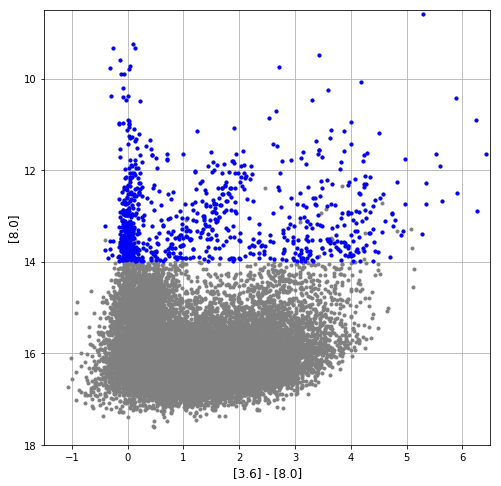

0.5278571428571429


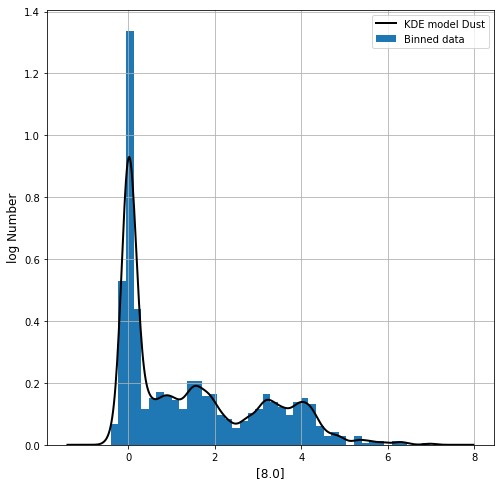

In [50]:
# 50

# where's the C-rich AGB star branch dust limit?

threesixMINUSeightzeroDUST = low_error_threesixMINUSeightzeroDATA[(low_error_threesixMINUSeightzeroDATA.k80mag < 14.0)]
                                                                 #& (low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero < 6.98)]

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.plot(threesixMINUSeightzeroDUST.threesixMINUSeightzero, threesixMINUSeightzeroDUST.k80mag, '.', color='blue')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)
#
plt.grid(True)
plt.show()
plt.close()
#
#
binwidth = stats.knuth_bin_width(threesixMINUSeightzeroDUST.threesixMINUSeightzero)
bin_number = (max(threesixMINUSeightzeroDUST.threesixMINUSeightzero)+binwidth)/binwidth
print(binwidth)
#
    
kde_data = threesixMINUSeightzeroDUST.threesixMINUSeightzero.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/3., binwidth/3.)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/6.)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model Dust')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')

#plt.xlim(2.475, 2.5)
#plt.ylim(0.068, 0.069)

plt.legend()
plt.xlabel('[8.0]', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
    
# DUST LIMIT
# [3.6]-[8.0] = 2.485

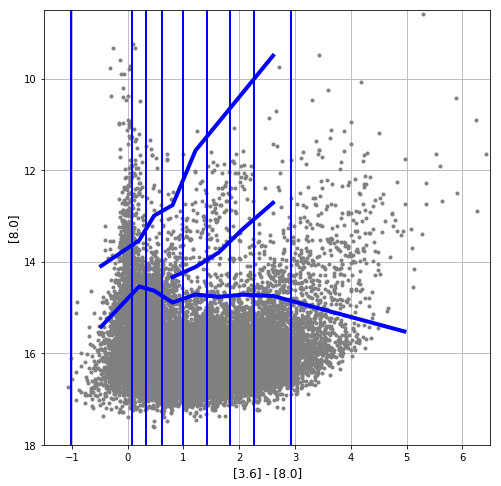

In [51]:
# 51

# CMD with vertical bins

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)

#
### where are the magnitude span bin midpoints?
#
#plt.axvline(x=-0.475, linewidth=1.0, color='cyan')
#plt.axvline(x=0.205, linewidth=1.0, color='cyan')
#plt.axvline(x=0.475, linewidth=1.0, color='cyan')
#plt.axvline(x=0.805, linewidth=1.0, color='cyan')
#plt.axvline(x=1.215, linewidth=1.0, color='cyan')
#plt.axvline(x=1.635, linewidth=1.0, color='cyan')
#plt.axvline(x=2.055, linewidth=1.0, color='cyan')
#plt.axvline(x=2.605, linewidth=1.0, color='cyan')
#plt.axvline(x=4.96, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axvline(x=-1.02, linewidth=2.0, color='blue')
plt.axvline(x=0.071, linewidth=2.0, color='blue')
plt.axvline(x=0.331, linewidth=2.0, color='blue')
plt.axvline(x=0.611, linewidth=2.0, color='blue')
plt.axvline(x=0.991, linewidth=2.0, color='blue')
plt.axvline(x=1.431, linewidth=2.0, color='blue')
plt.axvline(x=1.831, linewidth=2.0, color='blue')
plt.axvline(x=2.271, linewidth=2.0, color='blue')
plt.axvline(x=2.931, linewidth=2.0, color='blue')
plt.axvline(x=6.98, linewidth=2.0, color='blue')
#
### plot points (vertical bins)
#
xvaluesA = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 2.605])#, 4.96])
xvaluesB = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 1.635, 2.055, 2.605, 4.96])
xvaluesC = np.array([0.805, 1.215, 1.635, 2.055, 2.605])#, 4.96])
boundaryA = np.array([14.093, 13.535, 12.994, 12.764, 11.573, 9.5])
boundaryB = np.array([15.419, 14.541, 14.633, 14.892, 14.717, 14.768, 14.721, 14.749, 15.524])
boundaryC = np.array([14.336, 14.116, 13.796, 13.294, 12.714])#, 1.256, 1.136, 1.264, 2.269])
#
plt.plot(xvaluesA, boundaryA, linewidth=4.0, color='blue')
plt.plot(xvaluesB, boundaryB, linewidth=4.0, color='blue')
plt.plot(xvaluesC, boundaryC, linewidth=4.0, color='blue')
#

#plt.axvline(x=2.485, linewidth=4.0, color='red') # Dust Boundary

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_squiggles_blue.pdf')


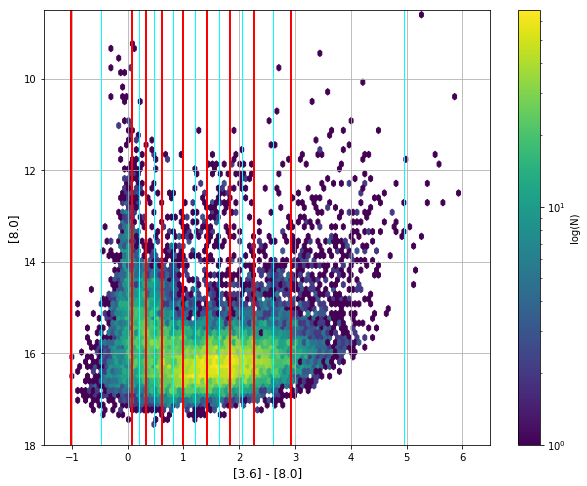

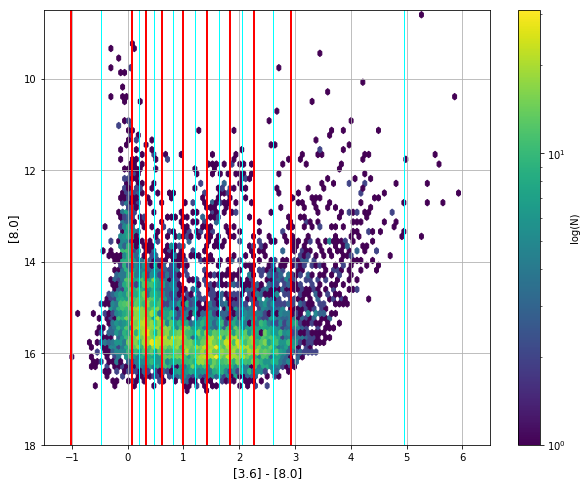

In [52]:
# 52

fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')

#
### where are the magnitude span bin midpoints?
#
plt.axvline(x=-0.475, linewidth=1.0, color='cyan')
plt.axvline(x=0.205, linewidth=1.0, color='cyan')
plt.axvline(x=0.475, linewidth=1.0, color='cyan')
plt.axvline(x=0.805, linewidth=1.0, color='cyan')
plt.axvline(x=1.215, linewidth=1.0, color='cyan')
plt.axvline(x=1.635, linewidth=1.0, color='cyan')
plt.axvline(x=2.055, linewidth=1.0, color='cyan')
plt.axvline(x=2.605, linewidth=1.0, color='cyan')
plt.axvline(x=4.96, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axvline(x=-1.02, linewidth=2.0, color='red')
plt.axvline(x=0.071, linewidth=2.0, color='red')
plt.axvline(x=0.331, linewidth=2.0, color='red')
plt.axvline(x=0.611, linewidth=2.0, color='red')
plt.axvline(x=0.991, linewidth=2.0, color='red')
plt.axvline(x=1.431, linewidth=2.0, color='red')
plt.axvline(x=1.831, linewidth=2.0, color='red')
plt.axvline(x=2.271, linewidth=2.0, color='red')
plt.axvline(x=2.931, linewidth=2.0, color='red')
plt.axvline(x=6.98, linewidth=2.0, color='red')
#
### plot points
#
#yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 14.060, 11.045])
#yvalues2 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 14.060, 11.045])
#yvalues3 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 14.060, 11.045])
#boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.154, 1.393, 1.240, 2.435])
#boundary2 = np.array([0.883, 0.918, 0.954, 0.940, 0.986, 1.075])
#boundary3 = np.array([0.988, 1.084, 1.256, 1.136, 1.264, 2.269])
#
#plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
#plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
#plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#plt.plot(boundary4, yvalues4, linewidth=4.0, color='red')
#
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_hist_binlines.pdf')

#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('[8.0]_vs_[3.6]-[8.0]_hist.pdf')

#
### where are the magnitude span bin midpoints?
#
plt.axvline(x=-0.475, linewidth=1.0, color='cyan')
plt.axvline(x=0.205, linewidth=1.0, color='cyan')
plt.axvline(x=0.475, linewidth=1.0, color='cyan')
plt.axvline(x=0.805, linewidth=1.0, color='cyan')
plt.axvline(x=1.215, linewidth=1.0, color='cyan')
plt.axvline(x=1.635, linewidth=1.0, color='cyan')
plt.axvline(x=2.055, linewidth=1.0, color='cyan')
plt.axvline(x=2.605, linewidth=1.0, color='cyan')
plt.axvline(x=4.96, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axvline(x=-1.02, linewidth=2.0, color='red')
plt.axvline(x=0.071, linewidth=2.0, color='red')
plt.axvline(x=0.331, linewidth=2.0, color='red')
plt.axvline(x=0.611, linewidth=2.0, color='red')
plt.axvline(x=0.991, linewidth=2.0, color='red')
plt.axvline(x=1.431, linewidth=2.0, color='red')
plt.axvline(x=1.831, linewidth=2.0, color='red')
plt.axvline(x=2.271, linewidth=2.0, color='red')
plt.axvline(x=2.931, linewidth=2.0, color='red')
plt.axvline(x=6.98, linewidth=2.0, color='red')
#
### plot points
#
#yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 14.060, 11.045])
#yvalues2 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 14.060, 11.045])
#yvalues3 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 14.060, 11.045])
#boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.154, 1.393, 1.240, 2.435])
#boundary2 = np.array([0.883, 0.918, 0.954, 0.940, 0.986, 1.075])
#boundary3 = np.array([0.988, 1.084, 1.256, 1.136, 1.264, 2.269])
#
#plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
#plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
#plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#plt.plot(boundary4, yvalues4, linewidth=4.0, color='red')
#
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_low-error_hist_binlines2.pdf')

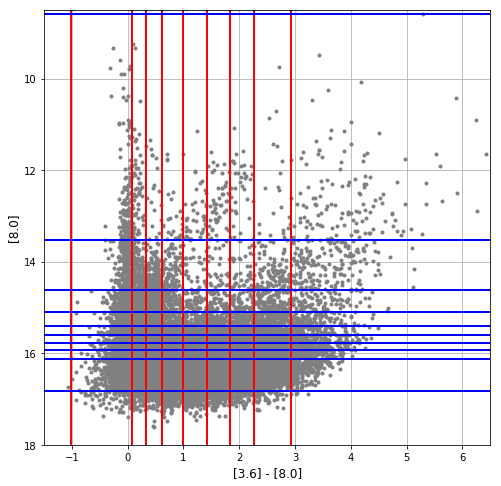

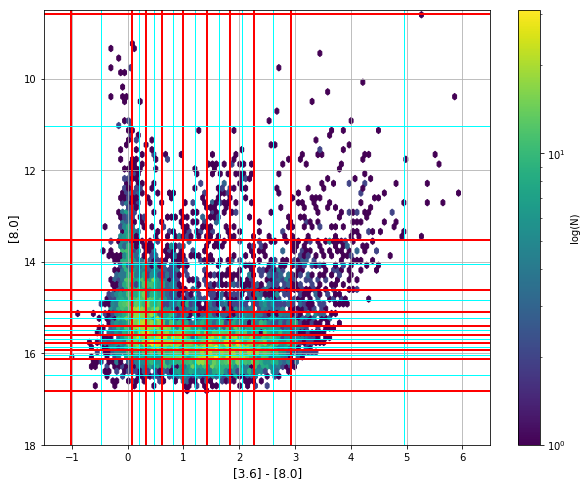

In [53]:
# 53

# CMD with horizontal AND vertical bins (just for fun)

plt.figure(figsize=(8, 8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)

#
### where are the magnitude span bin midpoints?
#
#plt.axvline(x=-0.475, linewidth=1.0, color='cyan')
#plt.axvline(x=0.205, linewidth=1.0, color='cyan')
#plt.axvline(x=0.475, linewidth=1.0, color='cyan')
#plt.axvline(x=0.805, linewidth=1.0, color='cyan')
#plt.axvline(x=1.215, linewidth=1.0, color='cyan')
#plt.axvline(x=1.635, linewidth=1.0, color='cyan')
#plt.axvline(x=2.055, linewidth=1.0, color='cyan')
#plt.axvline(x=2.605, linewidth=1.0, color='cyan')
#plt.axvline(x=4.96, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axvline(x=-1.02, linewidth=2.0, color='red')
plt.axvline(x=0.071, linewidth=2.0, color='red')
plt.axvline(x=0.331, linewidth=2.0, color='red')
plt.axvline(x=0.611, linewidth=2.0, color='red')
plt.axvline(x=0.991, linewidth=2.0, color='red')
plt.axvline(x=1.431, linewidth=2.0, color='red')
plt.axvline(x=1.831, linewidth=2.0, color='red')
plt.axvline(x=2.271, linewidth=2.0, color='red')
plt.axvline(x=2.931, linewidth=2.0, color='red')
plt.axvline(x=6.98, linewidth=2.0, color='red')
#
#
### where are the magnitude span bin midpoints?
#
#plt.axhline(y=16.480, linewidth=1.0, color='cyan')
#plt.axhline(y=16.030, linewidth=1.0, color='cyan')
#plt.axhline(y=15.855, linewidth=1.0, color='cyan')
#plt.axhline(y=15.690, linewidth=1.0, color='cyan')
#plt.axhline(y=15.500, linewidth=1.0, color='cyan')
#plt.axhline(y=15.240, linewidth=1.0, color='cyan')
#plt.axhline(y=14.845, linewidth=1.0, color='cyan')
#plt.axhline(y=14.060, linewidth=1.0, color='cyan')
#plt.axhline(y=11.045, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axhline(y=16.83, linewidth=2.0, color='blue')
plt.axhline(y=16.129, linewidth=2.0, color='blue')
plt.axhline(y=15.939, linewidth=2.0, color='blue')
plt.axhline(y=15.779, linewidth=2.0, color='blue')
plt.axhline(y=15.609, linewidth=2.0, color='blue')
plt.axhline(y=15.399, linewidth=2.0, color='blue')
plt.axhline(y=15.089, linewidth=2.0, color='blue')
plt.axhline(y=14.609, linewidth=2.0, color='blue')
plt.axhline(y=13.519, linewidth=2.0, color='blue')
plt.axhline(y=8.58, linewidth=2.0, color='blue')
#

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_bins_redblue.pdf')

#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')

#
### where are the magnitude span bin midpoints?
#
plt.axvline(x=-0.475, linewidth=1.0, color='cyan')
plt.axvline(x=0.205, linewidth=1.0, color='cyan')
plt.axvline(x=0.475, linewidth=1.0, color='cyan')
plt.axvline(x=0.805, linewidth=1.0, color='cyan')
plt.axvline(x=1.215, linewidth=1.0, color='cyan')
plt.axvline(x=1.635, linewidth=1.0, color='cyan')
plt.axvline(x=2.055, linewidth=1.0, color='cyan')
plt.axvline(x=2.605, linewidth=1.0, color='cyan')
plt.axvline(x=4.96, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axvline(x=-1.02, linewidth=2.0, color='red')
plt.axvline(x=0.071, linewidth=2.0, color='red')
plt.axvline(x=0.331, linewidth=2.0, color='red')
plt.axvline(x=0.611, linewidth=2.0, color='red')
plt.axvline(x=0.991, linewidth=2.0, color='red')
plt.axvline(x=1.431, linewidth=2.0, color='red')
plt.axvline(x=1.831, linewidth=2.0, color='red')
plt.axvline(x=2.271, linewidth=2.0, color='red')
plt.axvline(x=2.931, linewidth=2.0, color='red')
plt.axvline(x=6.98, linewidth=2.0, color='red')
#
#
### where are the magnitude span bin midpoints?
#
plt.axhline(y=16.480, linewidth=1.0, color='cyan')
plt.axhline(y=16.030, linewidth=1.0, color='cyan')
plt.axhline(y=15.855, linewidth=1.0, color='cyan')
plt.axhline(y=15.690, linewidth=1.0, color='cyan')
plt.axhline(y=15.500, linewidth=1.0, color='cyan')
plt.axhline(y=15.240, linewidth=1.0, color='cyan')
plt.axhline(y=14.845, linewidth=1.0, color='cyan')
plt.axhline(y=14.060, linewidth=1.0, color='cyan')
plt.axhline(y=11.045, linewidth=1.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axhline(y=16.83, linewidth=2.0, color='red')
plt.axhline(y=16.129, linewidth=2.0, color='red')
plt.axhline(y=15.939, linewidth=2.0, color='red')
plt.axhline(y=15.779, linewidth=2.0, color='red')
plt.axhline(y=15.609, linewidth=2.0, color='red')
plt.axhline(y=15.399, linewidth=2.0, color='red')
plt.axhline(y=15.089, linewidth=2.0, color='red')
plt.axhline(y=14.609, linewidth=2.0, color='red')
plt.axhline(y=13.519, linewidth=2.0, color='red')
plt.axhline(y=8.58, linewidth=2.0, color='red')
#

plt.grid(True)
plt.show()
plt.close()

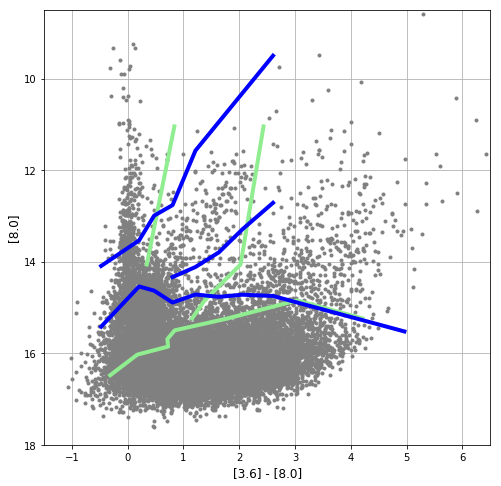

In [63]:
# 54

# Okay, now I've got the color-cut boundary lines for this CMD
# using both vertical and horizontal stacked box bins.
#
# Here I'm going to comine the lines from each analysis
# and figure out which ones I'll use to make the functional fits.

plt.figure(figsize=(8,8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)

#
### where are the magnitude span bin midpoints?
#
#plt.axhline(y=16.480, linewidth=2.0, color='magenta')
#plt.axhline(y=16.030, linewidth=2.0, color='magenta')
#plt.axhline(y=15.855, linewidth=2.0, color='magenta')
#plt.axhline(y=15.690, linewidth=2.0, color='magenta')
#plt.axhline(y=15.500, linewidth=2.0, color='magenta')
#plt.axhline(y=15.240, linewidth=2.0, color='magenta')
#plt.axhline(y=14.845, linewidth=2.0, color='magenta')
#plt.axhline(y=14.060, linewidth=2.0, color='magenta')
#plt.axhline(y=11.045, linewidth=2.0, color='magenta')
#
### where are the bin boundaries?
#
#plt.axhline(y=16.83, linewidth=2.0, color='lightgreen')
#plt.axhline(y=16.129, linewidth=2.0, color='lightgreen')
#plt.axhline(y=15.939, linewidth=2.0, color='lightgreen')
#plt.axhline(y=15.779, linewidth=2.0, color='lightgreen')
#plt.axhline(y=15.609, linewidth=2.0, color='lightgreen')
#plt.axhline(y=15.399, linewidth=2.0, color='lightgreen')
#plt.axhline(y=15.089, linewidth=2.0, color='lightgreen')
#plt.axhline(y=14.609, linewidth=2.0, color='lightgreen')
#plt.axhline(y=13.519, linewidth=2.0, color='lightgreen')
#plt.axhline(y=8.58, linewidth=2.0, color='lightgreen')
#
### plot points
#
yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 15.240])#, 14.060])#, 11.045])
yvalues2 = np.array([15.240, 14.845, 14.060, 11.045])
yvalues3 = np.array([14.060, 11.045])
boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.790, 3.037, 4.206])#, 2.435])
boundary1 = np.array([-0.313, 0.173, 0.725, 0.712, 0.843, 1.790, 3.037, 4.206])#, 2.435])
boundary2 = np.array([1.154, 1.380, 2.024, 2.435])
boundary3 = np.array([0.343, 0.837])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='lightgreen')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='lightgreen')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='lightgreen')
#
#
### where are the magnitude span bin midpoints?
#
#plt.axvline(x=-0.475, linewidth=2.0, color='cyan')
#plt.axvline(x=0.205, linewidth=2.0, color='cyan')
#plt.axvline(x=0.475, linewidth=2.0, color='cyan')
#plt.axvline(x=0.805, linewidth=2.0, color='cyan')
#plt.axvline(x=1.215, linewidth=2.0, color='cyan')
#plt.axvline(x=1.635, linewidth=2.0, color='cyan')
#plt.axvline(x=2.055, linewidth=2.0, color='cyan')
#plt.axvline(x=2.605, linewidth=2.0, color='cyan')
#plt.axvline(x=4.96, linewidth=2.0, color='cyan')
#
### where are the bin boundaries?
#
#plt.axvline(x=-1.02, linewidth=2.0, color='blue')
#plt.axvline(x=0.071, linewidth=2.0, color='blue')
#plt.axvline(x=0.331, linewidth=2.0, color='blue')
#plt.axvline(x=0.611, linewidth=2.0, color='blue')
#plt.axvline(x=0.991, linewidth=2.0, color='blue')
#plt.axvline(x=1.431, linewidth=2.0, color='blue')
#plt.axvline(x=1.831, linewidth=2.0, color='blue')
#plt.axvline(x=2.271, linewidth=2.0, color='blue')
#plt.axvline(x=2.931, linewidth=2.0, color='blue')
#plt.axvline(x=6.98, linewidth=2.0, color='blue')
#
### plot points (vertical bins)
#
xvaluesA = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 2.605])#, 4.96])
xvaluesB = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 1.635, 2.055, 2.605, 4.96])
xvaluesC = np.array([0.805, 1.215, 1.635, 2.055, 2.605])#, 4.96])
boundaryA = np.array([14.093, 13.535, 12.994, 12.764, 11.573, 9.5])
boundaryB = np.array([15.419, 14.541, 14.633, 14.892, 14.717, 14.768, 14.721, 14.749, 15.524])
boundaryC = np.array([14.336, 14.116, 13.796, 13.294, 12.714])#, 1.256, 1.136, 1.264, 2.269])
#
plt.plot(xvaluesA, boundaryA, linewidth=4.0, color='blue')
plt.plot(xvaluesB, boundaryB, linewidth=4.0, color='blue')
plt.plot(xvaluesC, boundaryC, linewidth=4.0, color='blue')
#

#plt.axvline(x=2.485, linewidth=4.0, color='brown') # Dust Boundary

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_squiggles_greenblue.pdf')

In [55]:
# 55

# That looks like a huge mess.
#
# I've color-coded the lines to know what comes from what,
# where red comes from the vertically-stacked bins and
# the blue comes from the horizontally-stacked bins.
#
# The boundary lines in the lower-right actually sit
# *right on top of each other*, so that's awesome!
#
# In general, I want to try to separate out five different regions.
#
# These are going to be:
#
# [1] foreground and main sequence stars
#     These are going to be the vertical structure at color = zero.
#
# [2] O-rich AGB star candidates
#     These are below [1], but above background galaxies [5].
#
# [3] C-rich AGB star candidates
#     These are the diagonal structure going up and to the right
#     growing out of the [2] region.
#
# [4] dust enshrouded and YSOs
#     These are the points in the diffuse region in the upper-right
#     region of the CMD, above background galaxies [5].
#
# [5] background galaxies
#     The primary number of points in the bottom of the CMD, underneath
#     essentially all the other types, stretching from left to right.
#
# The boundary between [1] and [3] will be the blue line, not the red line,
# but the bottom part might use the red line, depending on the borders for [2].
#
# The boundary between [4] and [5] will follow the blue line, not the red line,
# but they co-exist for a long stretch of the border so that's good.
#
# The boundary between [3] and [4] will follow the blue line, not the red line,
# at least until it hits the gray line (dust limit).
#
# I'm still worried about the boundary between [1] and [2], and [2] and [5].

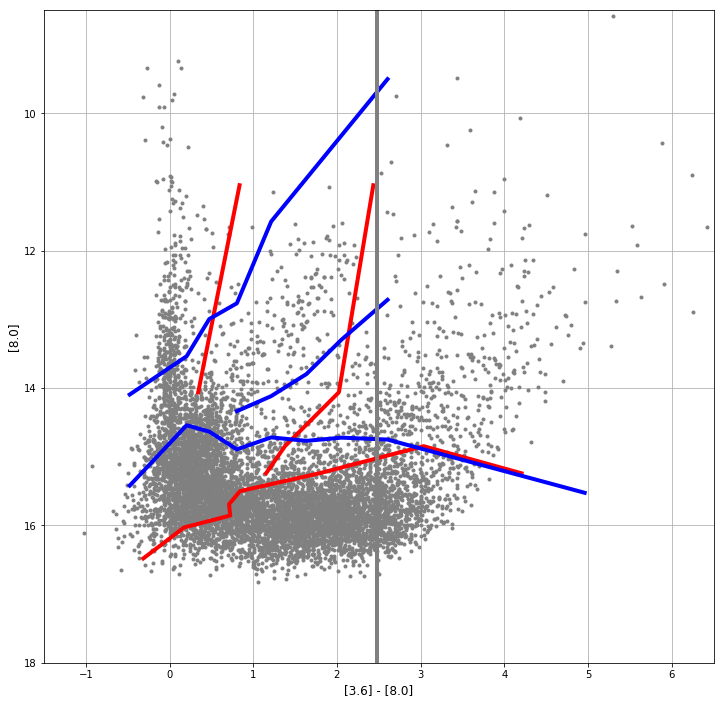

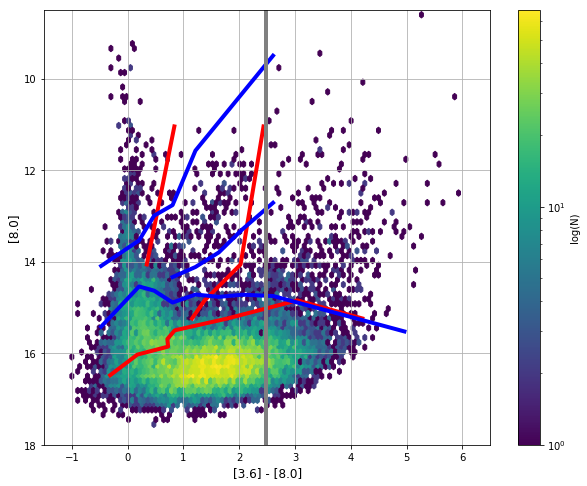

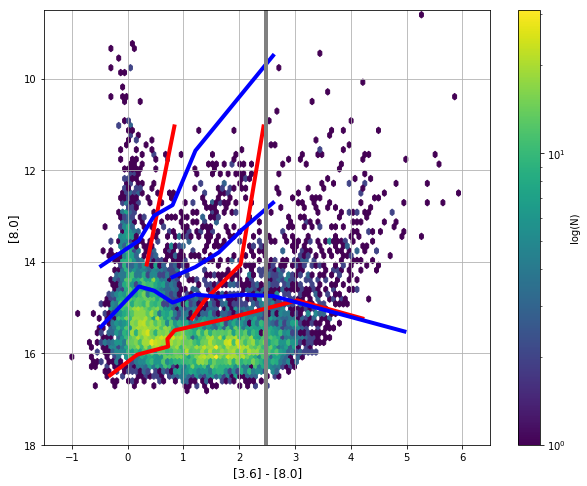

In [56]:
# 56

# This cell is to visualize where the boundaries are with the Hess diagrams,
# including ALL points and only LOW-ERROR points.

plt.figure(figsize=(12,12))
plt.plot(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)

#
### plot points (horizontal bins)
#
yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 15.240])#, 14.060])#, 11.045])
yvalues2 = np.array([15.240, 14.845, 14.060, 11.045])
yvalues3 = np.array([14.060, 11.045])
boundary1 = np.array([-0.313, 0.173, 0.725, 0.712, 0.843, 1.790, 3.037, 4.206])#, 2.435])
#boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.790, 3.037, 4.206])#, 2.435])
boundary2 = np.array([1.154, 1.380, 2.024, 2.435])
boundary3 = np.array([0.343, 0.837])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#
#
### plot points (vertical bins)
#
xvaluesA = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 2.605])#, 4.96])
xvaluesB = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 1.635, 2.055, 2.605, 4.96])
xvaluesC = np.array([0.805, 1.215, 1.635, 2.055, 2.605])#, 4.96])
boundaryA = np.array([14.093, 13.535, 12.994, 12.764, 11.573, 9.5])
boundaryB = np.array([15.419, 14.541, 14.633, 14.892, 14.717, 14.768, 14.721, 14.749, 15.524])
boundaryC = np.array([14.336, 14.116, 13.796, 13.294, 12.714])#, 1.256, 1.136, 1.264, 2.269])
#
plt.plot(xvaluesA, boundaryA, linewidth=4.0, color='blue')
plt.plot(xvaluesB, boundaryB, linewidth=4.0, color='blue')
plt.plot(xvaluesC, boundaryC, linewidth=4.0, color='blue')
#

plt.axvline(x=2.485, linewidth=4.0, color='gray') # Dust Boundary

plt.grid(True)
plt.show()
plt.close()

# Hess Diagram

fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')

#
### plot points (horizontal bins)
#
yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 15.240])#, 14.060])#, 11.045])
yvalues2 = np.array([15.240, 14.845, 14.060, 11.045])
yvalues3 = np.array([14.060, 11.045])
boundary1 = np.array([-0.313, 0.173, 0.725, 0.712, 0.843, 1.790, 3.037, 4.206])#, 2.435])
#boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.790, 3.037, 4.206])#, 2.435])
boundary2 = np.array([1.154, 1.380, 2.024, 2.435])
boundary3 = np.array([0.343, 0.837])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#
#
### plot points (vertical bins)
#
xvaluesA = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 2.605])#, 4.96])
xvaluesB = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 1.635, 2.055, 2.605, 4.96])
xvaluesC = np.array([0.805, 1.215, 1.635, 2.055, 2.605])#, 4.96])
boundaryA = np.array([14.093, 13.535, 12.994, 12.764, 11.573, 9.5])
boundaryB = np.array([15.419, 14.541, 14.633, 14.892, 14.717, 14.768, 14.721, 14.749, 15.524])
boundaryC = np.array([14.336, 14.116, 13.796, 13.294, 12.714])#, 1.256, 1.136, 1.264, 2.269])
#
plt.plot(xvaluesA, boundaryA, linewidth=4.0, color='blue')
plt.plot(xvaluesB, boundaryB, linewidth=4.0, color='blue')
plt.plot(xvaluesC, boundaryC, linewidth=4.0, color='blue')
#

plt.axvline(x=2.485, linewidth=4.0, color='gray') # Dust Boundary

plt.grid(True)
plt.show()
plt.close()

# Hess Diagram (low errors)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
im1 = ax1.hexbin(low_error_threesixMINUSeightzeroDATA.threesixMINUSeightzero, low_error_threesixMINUSeightzeroDATA.k80mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('[3.6] - [8.0]', size=12)
ax1.set_ylabel('[8.0]', size=12)
cb = plt.colorbar(im1, label='log(N)')

#
### plot points (horizontal bins)
#
yvalues1 = np.array([16.480, 16.030, 15.855, 15.690, 15.500, 15.240, 14.845, 15.240])#, 14.060])#, 11.045])
yvalues2 = np.array([15.240, 14.845, 14.060, 11.045])
yvalues3 = np.array([14.060, 11.045])
boundary1 = np.array([-0.313, 0.173, 0.725, 0.712, 0.843, 1.790, 3.037, 4.206])#, 2.435])
#boundary1 = np.array([0.778, 1.122, 1.243, 1.216, 1.564, 1.790, 3.037, 4.206])#, 2.435])
boundary2 = np.array([1.154, 1.380, 2.024, 2.435])
boundary3 = np.array([0.343, 0.837])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#
#
### plot points (vertical bins)
#
xvaluesA = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 2.605])#, 4.96])
xvaluesB = np.array([-0.475, 0.205, 0.475, 0.805, 1.215, 1.635, 2.055, 2.605, 4.96])
xvaluesC = np.array([0.805, 1.215, 1.635, 2.055, 2.605])#, 4.96])
boundaryA = np.array([14.093, 13.535, 12.994, 12.764, 11.573, 9.5])
boundaryB = np.array([15.419, 14.541, 14.633, 14.892, 14.717, 14.768, 14.721, 14.749, 15.524])
boundaryC = np.array([14.336, 14.116, 13.796, 13.294, 12.714])#, 1.256, 1.136, 1.264, 2.269])
#
plt.plot(xvaluesA, boundaryA, linewidth=4.0, color='blue')
plt.plot(xvaluesB, boundaryB, linewidth=4.0, color='blue')
plt.plot(xvaluesC, boundaryC, linewidth=4.0, color='blue')
#

plt.axvline(x=2.485, linewidth=4.0, color='gray') # Dust Boundary

plt.grid(True)
plt.show()
plt.close()

-2.0293350234287137 14.56513599001135
0.22939163075694638 14.277034746683508
-2.2512994364633854 18.150893019039852
0.7494735199677259 14.332034845201285
-0.7348596518410998 16.22551993098799


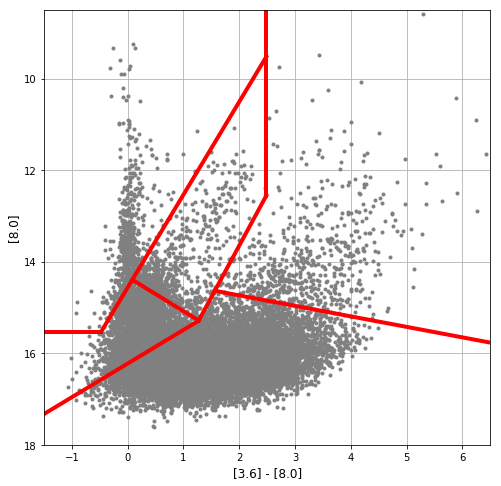

In [57]:
# 57

# POLYFIT

plt.figure(figsize=(8,8))
plt.plot(threesixMINUSeightzeroDATA.threesixMINUSeightzero, threesixMINUSeightzeroDATA.k80mag, '.', color='gray')
# low_error_
plt.xlim(-1.5, 6.5)
plt.ylim(18.0, 8.5)
plt.xlabel('[3.6] - [8.0]', size=12)
plt.ylabel('[8.0]', size=12)

xvalues1 = np.array([-0.475, 0.205, 0.343, 0.805, 1.215, 2.605])
xvalues2 = np.array([4.960, 4.206, 3.037, 2.605, 2.055, 1.380])#, 1.635, 2.055, 2.605, 1.215, 0.805])
xvalues3 = np.array([0.778, 1.122, 1.243, 1.216, 1.154, 1.380, 1.380, 1.635, 2.055, 2.605])#1.790, 3.037, 4.206]) 1.564, 
xvalues4 = np.array([0.205, 0.475, 0.805, 1.154])

#xvalues5 = np.array([1.380, 1.635, 2.055, 2.605]) # 0.805, 1.215, 
xvalues6 = np.array([-0.313, 0.173, 0.725, 0.712, 0.843])#, 1.790])

yvalues1 = np.array([15.419, 14.541, 14.060, 12.764, 11.573, 9.500])
yvalues2 = np.array([15.524, 15.240, 14.845, 14.749, 14.721, 14.768])#, 13.796, 13.294, 12.714, 14.717, 14.892])
yvalues3 = np.array([16.480, 16.030, 15.855, 15.690, 15.240, 14.845, 14.768, 13.796, 13.294, 12.714])#15.240, 14.845, 15.240]) 15.500, 
yvalues4 = np.array([14.541, 14.633, 14.892, 15.240])

#yvalues5 = np.array([14.768, 13.796, 13.294, 12.714]) # 14.892, 14.116, 
yvalues6 = np.array([16.480, 16.030, 15.855, 15.690, 15.500])#, 15.240])

#plt.plot(xvalues1, yvalues1, linewidth=4.0, color='red')
#plt.plot(xvalues2, yvalues2, linewidth=4.0, color='red')
#plt.plot(xvalues3, yvalues3, linewidth=4.0, color='red')
#plt.plot(xvalues4, yvalues4, linewidth=4.0, color='red')

#plt.plot(xvalues5, yvalues5, linewidth=4.0, color='red')
#plt.plot(xvalues6, yvalues6, linewidth=4.0, color='yellow')

from numpy.polynomial.polynomial import polyfit

b1, m1 = polyfit(xvalues1, yvalues1, 1)
print(m1, b1)
#plt.plot(xvalues1, b1 + m1 * xvalues1, '-', linewidth=3.0, color='blue')

b2, m2 = polyfit(xvalues2, yvalues2, 1)
print(m2, b2)
#plt.plot(xvalues2, b2 + m2 * xvalues2, '-', linewidth=3.0, color='blue')

b3, m3 = polyfit(xvalues3, yvalues3, 1)
print(m3, b3)
#plt.plot(xvalues3, b3 + m3 * xvalues3, '-', linewidth=3.0, color='blue')

b4, m4 = polyfit(xvalues4, yvalues4, 1)
print(m4, b4)
#plt.plot(xvalues4, b4 + m4 * xvalues4, '-', linewidth=3.0, color='blue')

b6, m6 = polyfit(xvalues6, yvalues6, 1)
print(m6, b6)
#plt.plot(xvalues6, b6 + m6 * xvalues6, '-', linewidth=3.0, color='orange')

# Boundary 1
#
x_Boundary1 = np.linspace(-0.475, 2.485, 100)
y_Boundary1 = -2.0293350234287137*x_Boundary1 + 14.56513599001135

# Boundary 2
#
x_Boundary2 = np.linspace(1.5616044752791755, 7.0, 100)
y_Boundary2 = 0.22939163075694638*x_Boundary2 + 14.277034746683508

# Boundary 3
#
x_Boundary3 = np.linspace(1.272624830097250, 2.485, 100) # (0.778, 2.485, 100)
y_Boundary3 = -2.2512994364633854*x_Boundary3 + 18.150893019039852

# Boundary 4
#
x_Boundary4 = np.linspace(0.08388528434749725, 1.272624830097250, 100)
y_Boundary4 = 0.7494735199677259*x_Boundary4 + 14.332034845201285

# Boundary 6
#
x_Boundary6 = np.linspace(-2.0, 1.272624830097250, 100)
y_Boundary6 = -0.7348596518410998*x_Boundary6 + 16.22551993098799

# plot lines
#

extremely_dusty = 2.485
left_line = 15.5291

plt.plot(x_Boundary1, y_Boundary1, linewidth=4.0, color='red')
plt.plot(x_Boundary2, y_Boundary2, linewidth=4.0, color='red')
plt.plot(x_Boundary3, y_Boundary3, linewidth=4.0, color='red')
plt.plot(x_Boundary4, y_Boundary4, linewidth=4.0, color='red')

plt.plot(x_Boundary6, y_Boundary6, linewidth=4.0, color='red')

y_extremely_dusty = np.linspace(12.5564, 8.0, 100)
x_extremely_dusty = 0.0*y_extremely_dusty + extremely_dusty
plt.plot(x_extremely_dusty, y_extremely_dusty, linewidth=4.0, color='red')

x_left_line = np.linspace(-12.0, -0.475, 100)
y_left_line = 0.0*x_left_line + left_line
plt.plot(x_left_line, y_left_line, linewidth=4.0, color='red')

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD3_boundaries.pdf')